In [ ]:
!pip install moviepy torch torchvision numpy opencv-python pillow facenet-pytorch tqdm moviepy face-alignment

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.7 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of facenet-pytorch to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 121.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/

In [ ]:
import os
import cv2
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
from moviepy.editor import VideoFileClip
from facenet_pytorch import MTCNN
import torchvision.transforms as transforms
import torchvision.models as models
import face_alignment
from google.colab import files
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns


  if event.key is 'enter':



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Dataset**

Videos are already downloaded using yt-dlp.

Google Drive Path: /content/drive/MyDrive/Sem-I/Multimodel Probilistic Machine Learning in Human Communication/Project/videos_mp4

In [ ]:
project_dir = '/content/drive/MyDrive/Sem-I/Multimodel Probilistic Machine Learning in Human Communication/Project'
csv_path = os.path.join(project_dir, 'dataset_annotation.csv')
video_dir = os.path.join(project_dir, 'videos_mp4')
features_dir = os.path.join(project_dir, 'features')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
# Load ResNet50 (without classification layer)
resnet = models.resnet50(pretrained=True)
resnet = torch.nn.Sequential(*list(resnet.children())[:-1])
resnet.eval().to(device)

# MTCNN face detector
mtcnn = MTCNN(keep_all=False, device=device)

# Face alignment for head pose
fa = face_alignment.FaceAlignment(landmarks_type='2D', device='cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


  warnings.warn(

  warnings.warn(msg)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 102MB/s]
Downloading: "https://www.adrianbulat.com/downloads/python-fan/s3fd-619a316812.pth" to /root/.cache/torch/hub/checkpoints/s3fd-619a316812.pth
100%|██████████| 85.7M/85.7M [00:00<00:00, 109MB/s]
Downloading: "https://www.adrianbulat.com/downloads/python-fan/3DFAN4-4a694010b9.zip" to /root/.cache/torch/hub/checkpoints/3DFAN4-4a694010b9.zip
100%|██████████| 91.9M/91.9M [00:00<00:00, 107MB/s]


In [ ]:
def estimate_head_pose(image_np):
    landmarks = fa.get_landmarks(image_np)
    if landmarks is None:
        return None
    landmarks = landmarks[0]

    image_points = np.array([
        landmarks[30], landmarks[8], landmarks[36],
        landmarks[45], landmarks[48], landmarks[54]
    ], dtype="double")

    model_points = np.array([
        (0.0, 0.0, 0.0),
        (0.0, -330.0, -65.0),
        (-225.0, 170.0, -135.0),
        (225.0, 170.0, -135.0),
        (-150.0, -150.0, -125.0),
        (150.0, -150.0, -125.0)
    ])

    h, w = image_np.shape[:2]
    focal_length = w
    center = (w // 2, h // 2)
    camera_matrix = np.array([
        [focal_length, 0, center[0]],
        [0, focal_length, center[1]],
        [0, 0, 1]
    ], dtype="double")
    dist_coeffs = np.zeros((4, 1))

    success, rot_vec, trans_vec = cv2.solvePnP(model_points, image_points, camera_matrix, dist_coeffs)
    if not success:
        return None

    rmat, _ = cv2.Rodrigues(rot_vec)
    pose_mat = cv2.hconcat((rmat, trans_vec))
    _, _, _, _, _, _, euler_angles = cv2.decomposeProjectionMatrix(pose_mat)
    yaw, pitch, roll = euler_angles.flatten().tolist()

    return yaw, pitch, roll


In [ ]:
def extract_face_embedding_and_pose(frame):
    img = Image.fromarray(frame)
    face_tensor = mtcnn(img)
    if face_tensor is None:
        return None
    face_tensor = face_tensor.unsqueeze(0).to(device)

    with torch.no_grad():
        embedding = resnet(face_tensor).squeeze().cpu().numpy()

    head_pose = estimate_head_pose(frame)
    if head_pose is None:
        head_pose = [0, 0, 0]

    return np.concatenate([embedding, np.array(head_pose)])

In [ ]:
def convert_str_to_list(input_string):
  try:
    return eval(input_string)
  except (SyntaxError, NameError):
    return None

In [ ]:
def get_escalation_after_face(time_stamps, first_face_time):
    if time_stamps is None or len(time_stamps) == 0:
        return None

    filtered_timestamps = [x for x in time_stamps if x > first_face_time]

    if len(filtered_timestamps) == 0:
        return None

    return float(min(filtered_timestamps))

In [ ]:
def process_video_escalation_controlled(row):
    video_file = row['titles']
    video_path = os.path.join(video_dir, video_file + '.mp4')
    escalation_times = convert_str_to_list(row['escalation_timestamps'])
    save_path = os.path.join(features_dir, video_file + '_features.npy')
    if os.path.exists(save_path):
        print(f"Skipping {video_file} as features already exist.")
        return

    clip = VideoFileClip(video_path)
    duration = int(clip.duration)

    first_face_time = None
    for t in range(0, duration, 2):
        frame = clip.get_frame(t)
        if mtcnn(Image.fromarray(frame)) is not None:
            first_face_time = t
            print(f"First face found at {t}s in {video_file}")
            break

    if first_face_time is None:
        print(f"No face found in video {video_file}. Skipping...")
        return

    escalation_time = get_escalation_after_face(escalation_times, first_face_time)
    end_time = min(duration, int(escalation_time + 60)) if escalation_time else duration

    features = []

    print(f"Processing {video_file} from {first_face_time}s to {end_time}s")
    for t in tqdm(range(first_face_time, end_time), desc="Extracting features"):
        frame = clip.get_frame(t)
        feature_vec = extract_face_embedding_and_pose(frame)
        if feature_vec is not None:
            features.append(feature_vec)

    features = np.array(features)
    print(f"Extracted {features.shape} features.")

    if features.shape[0] == 0:
        print(f"No features extracted for {video_file}")
        return

    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    np.save(save_path, features)
    print(f"Saved features to {save_path}")

In [ ]:
df = pd.read_csv("dataset_annotation.csv")
for idx,row in df.iterrows():
  process_video_escalation_controlled(row)


First face found at 6s in San Diego Police Officers Fatally Shoot Man Who Fired On Them
Processing San Diego Police Officers Fatally Shoot Man Who Fired On Them from 6s to 96s


Extracting features:  86%|████████▌ | 77/90 [01:35<00:12,  1.04it/s]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/face_alignment/api.py:147: UserWarning: No faces were detected.
  warnings.warn("No faces were detected.")

Extracting features: 100%|██████████| 90/90 [01:41<00:00,  1.13s/it]


Extracted (79, 2051) features.
Saved features to /content/drive/MyDrive/Sem-I/Multimodel Probilistic Machine Learning in Human Communication/Project/features/San Diego Police Officers Fatally Shoot Man Who Fired On Them_features.npy
First face found at 26s in Georgia Police Officer Pulls Over Chief Deputy For Speeding
Processing Georgia Police Officer Pulls Over Chief Deputy For Speeding from 26s to 133s


Extracting features: 100%|██████████| 107/107 [00:59<00:00,  1.79it/s]


Extracted (35, 2051) features.
Saved features to /content/drive/MyDrive/Sem-I/Multimodel Probilistic Machine Learning in Human Communication/Project/features/Georgia Police Officer Pulls Over Chief Deputy For Speeding_features.npy
First face found at 0s in Registered Violent Sexual Predator Tries To Run From Florida Police
Processing Registered Violent Sexual Predator Tries To Run From Florida Police from 0s to 106s


Extracting features: 100%|██████████| 106/106 [01:08<00:00,  1.55it/s]


Extracted (53, 2051) features.
Saved features to /content/drive/MyDrive/Sem-I/Multimodel Probilistic Machine Learning in Human Communication/Project/features/Registered Violent Sexual Predator Tries To Run From Florida Police_features.npy
First face found at 6s in Bodycam Footage of U.S. Marshal Fatally Shooting Omari Cryer in Louisville
Processing Bodycam Footage of U.S. Marshal Fatally Shooting Omari Cryer in Louisville from 6s to 66s


Extracting features: 100%|██████████| 60/60 [00:43<00:00,  1.38it/s]


Extracted (54, 2051) features.
Saved features to /content/drive/MyDrive/Sem-I/Multimodel Probilistic Machine Learning in Human Communication/Project/features/Bodycam Footage of U.S. Marshal Fatally Shooting Omari Cryer in Louisville_features.npy
First face found at 6s in Man Attacks Officer with Knife in Front of Police Station
Processing Man Attacks Officer with Knife in Front of Police Station from 6s to 97s


Extracting features: 100%|██████████| 91/91 [00:45<00:00,  1.98it/s]


Extracted (32, 2051) features.
Saved features to /content/drive/MyDrive/Sem-I/Multimodel Probilistic Machine Learning in Human Communication/Project/features/Man Attacks Officer with Knife in Front of Police Station_features.npy
First face found at 70s in Indiana Officer Rescues 2 Labrador Retrievers Clinging to Edge of icy Pond
Processing Indiana Officer Rescues 2 Labrador Retrievers Clinging to Edge of icy Pond from 70s to 89s


Extracting features: 100%|██████████| 19/19 [00:13<00:00,  1.43it/s]


Extracted (19, 2051) features.
Saved features to /content/drive/MyDrive/Sem-I/Multimodel Probilistic Machine Learning in Human Communication/Project/features/Indiana Officer Rescues 2 Labrador Retrievers Clinging to Edge of icy Pond_features.npy
First face found at 6s in Indianapolis Police Shoot Man Who Pointed Gun at an Officer
Processing Indianapolis Police Shoot Man Who Pointed Gun at an Officer from 6s to 97s


Extracting features: 100%|██████████| 91/91 [00:49<00:00,  1.82it/s]


Extracted (43, 2051) features.
Saved features to /content/drive/MyDrive/Sem-I/Multimodel Probilistic Machine Learning in Human Communication/Project/features/Indianapolis Police Shoot Man Who Pointed Gun at an Officer_features.npy
First face found at 6s in Man in Tactical Gear Shot After Charging at Officers With a Crowbar
Processing Man in Tactical Gear Shot After Charging at Officers With a Crowbar from 6s to 74s


Extracting features: 100%|██████████| 68/68 [00:49<00:00,  1.38it/s]


Extracted (30, 2051) features.
Saved features to /content/drive/MyDrive/Sem-I/Multimodel Probilistic Machine Learning in Human Communication/Project/features/Man in Tactical Gear Shot After Charging at Officers With a Crowbar_features.npy
First face found at 0s in Bodycam Captures Tampa Police Chief Using Position To Get Out of Traffic Violation
Processing Bodycam Captures Tampa Police Chief Using Position To Get Out of Traffic Violation from 0s to 134s


Extracting features: 100%|██████████| 134/134 [01:21<00:00,  1.65it/s]


Extracted (74, 2051) features.
Saved features to /content/drive/MyDrive/Sem-I/Multimodel Probilistic Machine Learning in Human Communication/Project/features/Bodycam Captures Tampa Police Chief Using Position To Get Out of Traffic Violation_features.npy
First face found at 32s in Cruiser Cam Shows Police Using PIT Maneuver To End a Chase in Dayton, Ohio
Processing Cruiser Cam Shows Police Using PIT Maneuver To End a Chase in Dayton, Ohio from 32s to 94s


Extracting features: 100%|██████████| 62/62 [00:31<00:00,  1.99it/s]


Extracted (22, 2051) features.
Saved features to /content/drive/MyDrive/Sem-I/Multimodel Probilistic Machine Learning in Human Communication/Project/features/Cruiser Cam Shows Police Using PIT Maneuver To End a Chase in Dayton, Ohio_features.npy
First face found at 40s in Man Almost Gets Shot by Cops After Answering Door With Gun in Hand
Processing Man Almost Gets Shot by Cops After Answering Door With Gun in Hand from 40s to 174s


Extracting features: 100%|██████████| 134/134 [01:20<00:00,  1.67it/s]


Extracted (60, 2051) features.
Saved features to /content/drive/MyDrive/Sem-I/Multimodel Probilistic Machine Learning in Human Communication/Project/features/Man Almost Gets Shot by Cops After Answering Door With Gun in Hand_features.npy
First face found at 10s in Officer Clings to Moving Car Before Firing Shots at Fleeing Suspect
Processing Officer Clings to Moving Car Before Firing Shots at Fleeing Suspect from 10s to 88s


Extracting features: 100%|██████████| 78/78 [00:47<00:00,  1.64it/s]


Extracted (15, 2051) features.
Saved features to /content/drive/MyDrive/Sem-I/Multimodel Probilistic Machine Learning in Human Communication/Project/features/Officer Clings to Moving Car Before Firing Shots at Fleeing Suspect_features.npy
First face found at 2s in Fort Wayne Police Officer Saves Toddler From Drowning in Pool
Processing Fort Wayne Police Officer Saves Toddler From Drowning in Pool from 2s to 98s


Extracting features: 100%|██████████| 96/96 [00:57<00:00,  1.68it/s]


Extracted (4, 2051) features.
Saved features to /content/drive/MyDrive/Sem-I/Multimodel Probilistic Machine Learning in Human Communication/Project/features/Fort Wayne Police Officer Saves Toddler From Drowning in Pool_features.npy
First face found at 0s in Helicopter Footage Shows Suspects in a Stolen BMW SUV Trying to Escape Deputies
Processing Helicopter Footage Shows Suspects in a Stolen BMW SUV Trying to Escape Deputies from 0s to 106s


Extracting features: 100%|██████████| 106/106 [01:00<00:00,  1.76it/s]


Extracted (54, 2051) features.
Saved features to /content/drive/MyDrive/Sem-I/Multimodel Probilistic Machine Learning in Human Communication/Project/features/Helicopter Footage Shows Suspects in a Stolen BMW SUV Trying to Escape Deputies_features.npy
First face found at 6s in San Diego Police Officer Shoots Man Walking Towards Him With a Knife
Processing San Diego Police Officer Shoots Man Walking Towards Him With a Knife from 6s to 70s


Extracting features: 100%|██████████| 64/64 [00:46<00:00,  1.38it/s]


Extracted (38, 2051) features.
Saved features to /content/drive/MyDrive/Sem-I/Multimodel Probilistic Machine Learning in Human Communication/Project/features/San Diego Police Officer Shoots Man Walking Towards Him With a Knife_features.npy
First face found at 10s in Bodycam Shows Moments Before Cop Shot Man Reaching For Officer's Gun
Processing Bodycam Shows Moments Before Cop Shot Man Reaching For Officer's Gun from 10s to 82s


Extracting features: 100%|██████████| 72/72 [00:46<00:00,  1.56it/s]


Extracted (24, 2051) features.
Saved features to /content/drive/MyDrive/Sem-I/Multimodel Probilistic Machine Learning in Human Communication/Project/features/Bodycam Shows Moments Before Cop Shot Man Reaching For Officer's Gun_features.npy
First face found at 38s in Police Officer Shoots Knife Wielding Suspect After Crashing Car Into Water
Processing Police Officer Shoots Knife Wielding Suspect After Crashing Car Into Water from 38s to 151s


Extracting features: 100%|██████████| 113/113 [01:41<00:00,  1.11it/s]


Extracted (85, 2051) features.
Saved features to /content/drive/MyDrive/Sem-I/Multimodel Probilistic Machine Learning in Human Communication/Project/features/Police Officer Shoots Knife Wielding Suspect After Crashing Car Into Water_features.npy
First face found at 16s in Deputies Shoot Woman As She Raises a Shotgun Toward Them
Processing Deputies Shoot Woman As She Raises a Shotgun Toward Them from 16s to 79s


Extracting features: 100%|██████████| 63/63 [00:40<00:00,  1.54it/s]


Extracted (19, 2051) features.
Saved features to /content/drive/MyDrive/Sem-I/Multimodel Probilistic Machine Learning in Human Communication/Project/features/Deputies Shoot Woman As She Raises a Shotgun Toward Them_features.npy
First face found at 0s in Cops Arrest Two Suspects After Being Caught Red-Handed With a Stolen Cash Register
Processing Cops Arrest Two Suspects After Being Caught Red-Handed With a Stolen Cash Register from 0s to 66s


Extracting features: 100%|██████████| 66/66 [00:41<00:00,  1.60it/s]


Extracted (8, 2051) features.
Saved features to /content/drive/MyDrive/Sem-I/Multimodel Probilistic Machine Learning in Human Communication/Project/features/Cops Arrest Two Suspects After Being Caught Red-Handed With a Stolen Cash Register_features.npy
First face found at 50s in Orlando Officer Drive Off After Deputy Pulls Him Over For Speeding
Processing Orlando Officer Drive Off After Deputy Pulls Him Over For Speeding from 50s to 156s


Extracting features: 100%|██████████| 106/106 [00:59<00:00,  1.78it/s]


Extracted (25, 2051) features.
Saved features to /content/drive/MyDrive/Sem-I/Multimodel Probilistic Machine Learning in Human Communication/Project/features/Orlando Officer Drive Off After Deputy Pulls Him Over For Speeding_features.npy
First face found at 50s in Bodycam Footage of Sandy Police Shooting 16-year-old in Stolen Army Van
Processing Bodycam Footage of Sandy Police Shooting 16-year-old in Stolen Army Van from 50s to 117s


Extracting features: 100%|██████████| 67/67 [00:45<00:00,  1.47it/s]


Extracted (25, 2051) features.
Saved features to /content/drive/MyDrive/Sem-I/Multimodel Probilistic Machine Learning in Human Communication/Project/features/Bodycam Footage of Sandy Police Shooting 16-year-old in Stolen Army Van_features.npy
First face found at 2s in Ohio Woman Rams Police Cars in Attempt to Escape Arrest
Processing Ohio Woman Rams Police Cars in Attempt to Escape Arrest from 2s to 85s


Extracting features: 100%|██████████| 83/83 [00:53<00:00,  1.56it/s]


Extracted (29, 2051) features.
Saved features to /content/drive/MyDrive/Sem-I/Multimodel Probilistic Machine Learning in Human Communication/Project/features/Ohio Woman Rams Police Cars in Attempt to Escape Arrest_features.npy
First face found at 6s in Santa Ana Police Shoot Armed Suspect During a Traffic Stop
Processing Santa Ana Police Shoot Armed Suspect During a Traffic Stop from 6s to 80s


Extracting features: 100%|██████████| 74/74 [00:47<00:00,  1.57it/s]


Extracted (30, 2051) features.
Saved features to /content/drive/MyDrive/Sem-I/Multimodel Probilistic Machine Learning in Human Communication/Project/features/Santa Ana Police Shoot Armed Suspect During a Traffic Stop_features.npy
First face found at 10s in Albuquerque Police Shoot Man While Trying to Wrestle Gun From His Hands
Processing Albuquerque Police Shoot Man While Trying to Wrestle Gun From His Hands from 10s to 88s


Extracting features: 100%|██████████| 78/78 [00:52<00:00,  1.50it/s]


Extracted (41, 2051) features.
Saved features to /content/drive/MyDrive/Sem-I/Multimodel Probilistic Machine Learning in Human Communication/Project/features/Albuquerque Police Shoot Man While Trying to Wrestle Gun From His Hands_features.npy
First face found at 56s in Cop Shoots at Restaurant Owner Holding Gun During Burglary Response
Processing Cop Shoots at Restaurant Owner Holding Gun During Burglary Response from 56s to 75s


Extracting features: 100%|██████████| 19/19 [00:14<00:00,  1.32it/s]


Extracted (19, 2051) features.
Saved features to /content/drive/MyDrive/Sem-I/Multimodel Probilistic Machine Learning in Human Communication/Project/features/Cop Shoots at Restaurant Owner Holding Gun During Burglary Response_features.npy
First face found at 24s in Bodycam Video Shows NYPD Cops Shooting Man Charging at Them With Knife
Processing Bodycam Video Shows NYPD Cops Shooting Man Charging at Them With Knife from 24s to 97s


Extracting features: 100%|██████████| 73/73 [01:04<00:00,  1.12it/s]


Extracted (47, 2051) features.
Saved features to /content/drive/MyDrive/Sem-I/Multimodel Probilistic Machine Learning in Human Communication/Project/features/Bodycam Video Shows NYPD Cops Shooting Man Charging at Them With Knife_features.npy
First face found at 16s in Officer Shoots Armed Man After He Points Gun in Greensboro Parking Lot
Processing Officer Shoots Armed Man After He Points Gun in Greensboro Parking Lot from 16s to 85s


Extracting features: 100%|██████████| 69/69 [00:45<00:00,  1.52it/s]


Extracted (30, 2051) features.
Saved features to /content/drive/MyDrive/Sem-I/Multimodel Probilistic Machine Learning in Human Communication/Project/features/Officer Shoots Armed Man After He Points Gun in Greensboro Parking Lot_features.npy
First face found at 68s in Three Teenage Carjacking Suspects Lead Seattle Police on a High-Speed Chase
Processing Three Teenage Carjacking Suspects Lead Seattle Police on a High-Speed Chase from 68s to 103s


Extracting features: 100%|██████████| 35/35 [00:24<00:00,  1.44it/s]


Extracted (23, 2051) features.
Saved features to /content/drive/MyDrive/Sem-I/Multimodel Probilistic Machine Learning in Human Communication/Project/features/Three Teenage Carjacking Suspects Lead Seattle Police on a High-Speed Chase_features.npy
First face found at 42s in DUI Suspect Crashes into JSO Cruiser on Mathews Bridge
Processing DUI Suspect Crashes into JSO Cruiser on Mathews Bridge from 42s to 104s


Extracting features: 100%|██████████| 62/62 [00:34<00:00,  1.81it/s]


Extracted (21, 2051) features.
Saved features to /content/drive/MyDrive/Sem-I/Multimodel Probilistic Machine Learning in Human Communication/Project/features/DUI Suspect Crashes into JSO Cruiser on Mathews Bridge_features.npy
First face found at 34s in Armed Suspects Toss Guns While Fleeing Police
Processing Armed Suspects Toss Guns While Fleeing Police from 34s to 106s


Extracting features: 100%|██████████| 72/72 [00:43<00:00,  1.67it/s]


Extracted (18, 2051) features.
Saved features to /content/drive/MyDrive/Sem-I/Multimodel Probilistic Machine Learning in Human Communication/Project/features/Armed Suspects Toss Guns While Fleeing Police_features.npy
First face found at 18s in Pueblo County Deputy Goes Unconscious During an Arrest For Suspected Fentanyl Possession
Processing Pueblo County Deputy Goes Unconscious During an Arrest For Suspected Fentanyl Possession from 18s to 134s


Extracting features: 100%|██████████| 116/116 [01:07<00:00,  1.71it/s]


Extracted (57, 2051) features.
Saved features to /content/drive/MyDrive/Sem-I/Multimodel Probilistic Machine Learning in Human Communication/Project/features/Pueblo County Deputy Goes Unconscious During an Arrest For Suspected Fentanyl Possession_features.npy
First face found at 0s in Hightstown Police Officers Save Choking Baby
Processing Hightstown Police Officers Save Choking Baby from 0s to 66s


Extracting features: 100%|██████████| 66/66 [00:48<00:00,  1.37it/s]


Extracted (36, 2051) features.
Saved features to /content/drive/MyDrive/Sem-I/Multimodel Probilistic Machine Learning in Human Communication/Project/features/Hightstown Police Officers Save Choking Baby_features.npy
First face found at 8s in Suspect Armed With Screwdriver Shot By LA Deputies
Processing Suspect Armed With Screwdriver Shot By LA Deputies from 8s to 71s


Extracting features: 100%|██████████| 63/63 [00:32<00:00,  1.97it/s]


Extracted (19, 2051) features.
Saved features to /content/drive/MyDrive/Sem-I/Multimodel Probilistic Machine Learning in Human Communication/Project/features/Suspect Armed With Screwdriver Shot By LA Deputies_features.npy
First face found at 12s in Seattle Police Harbor Patrol Officers Rescue Man From Drowning in Portage Bay
Processing Seattle Police Harbor Patrol Officers Rescue Man From Drowning in Portage Bay from 12s to 81s


Extracting features: 100%|██████████| 69/69 [00:39<00:00,  1.74it/s]


Extracted (17, 2051) features.
Saved features to /content/drive/MyDrive/Sem-I/Multimodel Probilistic Machine Learning in Human Communication/Project/features/Seattle Police Harbor Patrol Officers Rescue Man From Drowning in Portage Bay_features.npy
First face found at 22s in Police Use Taser to Subdue Knife-Wielding Man After Crashing Into 7-Eleven
Processing Police Use Taser to Subdue Knife-Wielding Man After Crashing Into 7-Eleven from 22s to 91s


Extracting features: 100%|██████████| 69/69 [00:42<00:00,  1.64it/s]


Extracted (34, 2051) features.
Saved features to /content/drive/MyDrive/Sem-I/Multimodel Probilistic Machine Learning in Human Communication/Project/features/Police Use Taser to Subdue Knife-Wielding Man After Crashing Into 7-Eleven_features.npy
First face found at 8s in Bodycam Footage of Stockton Officer Shooting Woman After Chase
Processing Bodycam Footage of Stockton Officer Shooting Woman After Chase from 8s to 157s


Extracting features: 100%|██████████| 149/149 [01:08<00:00,  2.19it/s]


Extracted (18, 2051) features.
Saved features to /content/drive/MyDrive/Sem-I/Multimodel Probilistic Machine Learning in Human Communication/Project/features/Bodycam Footage of Stockton Officer Shooting Woman After Chase_features.npy
First face found at 6s in Orange County Deputies Shoot Man Who Charged at Them With a Knife
Processing Orange County Deputies Shoot Man Who Charged at Them With a Knife from 6s to 113s


Extracting features: 100%|██████████| 107/107 [01:11<00:00,  1.49it/s]


Extracted (53, 2051) features.
Saved features to /content/drive/MyDrive/Sem-I/Multimodel Probilistic Machine Learning in Human Communication/Project/features/Orange County Deputies Shoot Man Who Charged at Them With a Knife_features.npy
First face found at 36s in Parolee Drowns in Hudson River While Attempting to Flee From Police on a Bicycle
Processing Parolee Drowns in Hudson River While Attempting to Flee From Police on a Bicycle from 36s to 170s


Extracting features: 100%|██████████| 134/134 [01:28<00:00,  1.51it/s]


Extracted (40, 2051) features.
Saved features to /content/drive/MyDrive/Sem-I/Multimodel Probilistic Machine Learning in Human Communication/Project/features/Parolee Drowns in Hudson River While Attempting to Flee From Police on a Bicycle_features.npy
First face found at 14s in Murder Suspect Gets Shot After Advancing Towards LA Deputies With a Knife
Processing Murder Suspect Gets Shot After Advancing Towards LA Deputies With a Knife from 14s to 77s


Extracting features: 100%|██████████| 63/63 [00:44<00:00,  1.41it/s]


Extracted (36, 2051) features.
Saved features to /content/drive/MyDrive/Sem-I/Multimodel Probilistic Machine Learning in Human Communication/Project/features/Murder Suspect Gets Shot After Advancing Towards LA Deputies With a Knife_features.npy
First face found at 10s in Armed Suspect Shot by San Antonio Officer During Drainage Ditch Pursuit
Processing Armed Suspect Shot by San Antonio Officer During Drainage Ditch Pursuit from 10s to 88s


Extracting features: 100%|██████████| 78/78 [00:54<00:00,  1.43it/s]


Extracted (38, 2051) features.
Saved features to /content/drive/MyDrive/Sem-I/Multimodel Probilistic Machine Learning in Human Communication/Project/features/Armed Suspect Shot by San Antonio Officer During Drainage Ditch Pursuit_features.npy
First face found at 4s in NYPD Cop Strikes Woman Interfering in Arrest of Armed Attempted Murder Suspect
Processing NYPD Cop Strikes Woman Interfering in Arrest of Armed Attempted Murder Suspect from 4s to 75s


Extracting features: 100%|██████████| 71/71 [01:02<00:00,  1.14it/s]


Extracted (52, 2051) features.
Saved features to /content/drive/MyDrive/Sem-I/Multimodel Probilistic Machine Learning in Human Communication/Project/features/NYPD Cop Strikes Woman Interfering in Arrest of Armed Attempted Murder Suspect_features.npy
First face found at 38s in Long Beach Officer Shoots Suspect After He Pulls a Gun Out of His Pocket
Processing Long Beach Officer Shoots Suspect After He Pulls a Gun Out of His Pocket from 38s to 171s


Extracting features: 100%|██████████| 133/133 [01:33<00:00,  1.42it/s]


Extracted (84, 2051) features.
Saved features to /content/drive/MyDrive/Sem-I/Multimodel Probilistic Machine Learning in Human Communication/Project/features/Long Beach Officer Shoots Suspect After He Pulls a Gun Out of His Pocket_features.npy
First face found at 8s in Florida Deputies Borrow Family's Boat To Arrest Jet Ski Theft Suspect
Processing Florida Deputies Borrow Family's Boat To Arrest Jet Ski Theft Suspect from 8s to 98s


Extracting features: 100%|██████████| 90/90 [00:46<00:00,  1.94it/s]


Extracted (18, 2051) features.
Saved features to /content/drive/MyDrive/Sem-I/Multimodel Probilistic Machine Learning in Human Communication/Project/features/Florida Deputies Borrow Family's Boat To Arrest Jet Ski Theft Suspect_features.npy
First face found at 6s in Man Shoots a Rookie NYPD Cop Over a Bus Seat
Processing Man Shoots a Rookie NYPD Cop Over a Bus Seat from 6s to 96s


Extracting features: 100%|██████████| 90/90 [00:59<00:00,  1.51it/s]


Extracted (56, 2051) features.
Saved features to /content/drive/MyDrive/Sem-I/Multimodel Probilistic Machine Learning in Human Communication/Project/features/Man Shoots a Rookie NYPD Cop Over a Bus Seat_features.npy
First face found at 6s in Pursuit Ends in Deputy-Involved Shooting After Suspect Drives Away During a Traffic Stop
Processing Pursuit Ends in Deputy-Involved Shooting After Suspect Drives Away During a Traffic Stop from 6s to 83s


Extracting features: 100%|██████████| 77/77 [00:45<00:00,  1.70it/s]


Extracted (40, 2051) features.
Saved features to /content/drive/MyDrive/Sem-I/Multimodel Probilistic Machine Learning in Human Communication/Project/features/Pursuit Ends in Deputy-Involved Shooting After Suspect Drives Away During a Traffic Stop_features.npy
First face found at 2s in Kalamazoo Police Officers Rescue Man Trapped Under Van
Processing Kalamazoo Police Officers Rescue Man Trapped Under Van from 2s to 92s


Extracting features: 100%|██████████| 90/90 [01:01<00:00,  1.45it/s]


Extracted (44, 2051) features.
Saved features to /content/drive/MyDrive/Sem-I/Multimodel Probilistic Machine Learning in Human Communication/Project/features/Kalamazoo Police Officers Rescue Man Trapped Under Van_features.npy
First face found at 26s in Florida Woman Attempts to Scale Apartment Building to Avoid Arrest
Processing Florida Woman Attempts to Scale Apartment Building to Avoid Arrest from 26s to 81s


Extracting features: 100%|██████████| 55/55 [00:37<00:00,  1.46it/s]


Extracted (31, 2051) features.
Saved features to /content/drive/MyDrive/Sem-I/Multimodel Probilistic Machine Learning in Human Communication/Project/features/Florida Woman Attempts to Scale Apartment Building to Avoid Arrest_features.npy
First face found at 16s in 14-year-old Boy Crashes Stolen Car while Fleeing From Officers on icy Roads
Processing 14-year-old Boy Crashes Stolen Car while Fleeing From Officers on icy Roads from 16s to 156s


Extracting features: 100%|██████████| 140/140 [01:26<00:00,  1.62it/s]


Extracted (40, 2051) features.
Saved features to /content/drive/MyDrive/Sem-I/Multimodel Probilistic Machine Learning in Human Communication/Project/features/14-year-old Boy Crashes Stolen Car while Fleeing From Officers on icy Roads_features.npy
First face found at 36s in Bodycam Shows Officers Catch Fleeing Suspect After Burglary in Atlanta, Georgia
Processing Bodycam Shows Officers Catch Fleeing Suspect After Burglary in Atlanta, Georgia from 36s to 49s


Extracting features: 100%|██████████| 13/13 [00:07<00:00,  1.73it/s]


Extracted (1, 2051) features.
Saved features to /content/drive/MyDrive/Sem-I/Multimodel Probilistic Machine Learning in Human Communication/Project/features/Bodycam Shows Officers Catch Fleeing Suspect After Burglary in Atlanta, Georgia_features.npy
First face found at 18s in Ohio Cop Sparta Kicks Suspect
Processing Ohio Cop Sparta Kicks Suspect from 18s to 147s


Extracting features: 100%|██████████| 129/129 [01:28<00:00,  1.45it/s]


Extracted (81, 2051) features.
Saved features to /content/drive/MyDrive/Sem-I/Multimodel Probilistic Machine Learning in Human Communication/Project/features/Ohio Cop Sparta Kicks Suspect_features.npy
First face found at 8s in Bodycam Shows Car Theft Suspect Repeatedly Reach For Officer’s Gun During a Struggle
Processing Bodycam Shows Car Theft Suspect Repeatedly Reach For Officer’s Gun During a Struggle from 8s to 92s


Extracting features: 100%|██████████| 84/84 [00:53<00:00,  1.57it/s]


Extracted (30, 2051) features.
Saved features to /content/drive/MyDrive/Sem-I/Multimodel Probilistic Machine Learning in Human Communication/Project/features/Bodycam Shows Car Theft Suspect Repeatedly Reach For Officer’s Gun During a Struggle_features.npy
First face found at 18s in LA County Deputy Shoots Armed Robbery Suspect Through Windshield
Processing LA County Deputy Shoots Armed Robbery Suspect Through Windshield from 18s to 170s


Extracting features: 100%|██████████| 152/152 [01:35<00:00,  1.59it/s]


Extracted (60, 2051) features.
Saved features to /content/drive/MyDrive/Sem-I/Multimodel Probilistic Machine Learning in Human Communication/Project/features/LA County Deputy Shoots Armed Robbery Suspect Through Windshield_features.npy
First face found at 6s in Florida SWAT Sniper Shoots Bank Robbery Suspect Through Computer Monitor During a Hostage Situation
Processing Florida SWAT Sniper Shoots Bank Robbery Suspect Through Computer Monitor During a Hostage Situation from 6s to 101s


Extracting features: 100%|██████████| 95/95 [01:00<00:00,  1.58it/s]


Extracted (57, 2051) features.
Saved features to /content/drive/MyDrive/Sem-I/Multimodel Probilistic Machine Learning in Human Communication/Project/features/Florida SWAT Sniper Shoots Bank Robbery Suspect Through Computer Monitor During a Hostage Situation_features.npy
First face found at 4s in Florida Deputy Jumps into Canal to Rescue Stranded Dog
Processing Florida Deputy Jumps into Canal to Rescue Stranded Dog from 4s to 166s


Extracting features: 100%|██████████| 162/162 [02:10<00:00,  1.24it/s]


Extracted (85, 2051) features.
Saved features to /content/drive/MyDrive/Sem-I/Multimodel Probilistic Machine Learning in Human Communication/Project/features/Florida Deputy Jumps into Canal to Rescue Stranded Dog_features.npy
First face found at 4s in Deputies Shoot Armed Suspect After Pursuit Ends in 7-11 Crash
Processing Deputies Shoot Armed Suspect After Pursuit Ends in 7-11 Crash from 4s to 79s


Extracting features: 100%|██████████| 75/75 [00:57<00:00,  1.31it/s]


Extracted (38, 2051) features.
Saved features to /content/drive/MyDrive/Sem-I/Multimodel Probilistic Machine Learning in Human Communication/Project/features/Deputies Shoot Armed Suspect After Pursuit Ends in 7-11 Crash_features.npy
First face found at 8s in Suspect Gets Shot After Pointing Gun at Officers in Boise, Idaho
Processing Suspect Gets Shot After Pointing Gun at Officers in Boise, Idaho from 8s to 69s


Extracting features: 100%|██████████| 61/61 [00:41<00:00,  1.47it/s]


Extracted (21, 2051) features.
Saved features to /content/drive/MyDrive/Sem-I/Multimodel Probilistic Machine Learning in Human Communication/Project/features/Suspect Gets Shot After Pointing Gun at Officers in Boise, Idaho_features.npy
First face found at 6s in Car Launches Off Tow Truck Ramp in Lowndes County, Georgia
Processing Car Launches Off Tow Truck Ramp in Lowndes County, Georgia from 6s to 63s


Extracting features: 100%|██████████| 57/57 [00:36<00:00,  1.56it/s]


Extracted (22, 2051) features.
Saved features to /content/drive/MyDrive/Sem-I/Multimodel Probilistic Machine Learning in Human Communication/Project/features/Car Launches Off Tow Truck Ramp in Lowndes County, Georgia_features.npy
First face found at 8s in Albuquerque Police Officers Chase Shoplifting Suspect on Horseback
Processing Albuquerque Police Officers Chase Shoplifting Suspect on Horseback from 8s to 70s


Extracting features: 100%|██████████| 62/62 [00:27<00:00,  2.29it/s]


Extracted (8, 2051) features.
Saved features to /content/drive/MyDrive/Sem-I/Multimodel Probilistic Machine Learning in Human Communication/Project/features/Albuquerque Police Officers Chase Shoplifting Suspect on Horseback_features.npy
First face found at 6s in Fresno Officer Shoots Masked 15-year-old Boy Pulling Replica Gun From Waistband
Processing Fresno Officer Shoots Masked 15-year-old Boy Pulling Replica Gun From Waistband from 6s to 76s


Extracting features: 100%|██████████| 70/70 [00:59<00:00,  1.17it/s]


Extracted (56, 2051) features.
Saved features to /content/drive/MyDrive/Sem-I/Multimodel Probilistic Machine Learning in Human Communication/Project/features/Fresno Officer Shoots Masked 15-year-old Boy Pulling Replica Gun From Waistband_features.npy
First face found at 6s in San Marcos Police Officer Shoots Suspect Armed With Knives During Foot Pursuit
Processing San Marcos Police Officer Shoots Suspect Armed With Knives During Foot Pursuit from 6s to 90s


Extracting features: 100%|██████████| 84/84 [00:59<00:00,  1.42it/s]


Extracted (32, 2051) features.
Saved features to /content/drive/MyDrive/Sem-I/Multimodel Probilistic Machine Learning in Human Communication/Project/features/San Marcos Police Officer Shoots Suspect Armed With Knives During Foot Pursuit_features.npy
First face found at 2s in Trooper Catches Dog Trying To Flee From a Traffic Stop
Processing Trooper Catches Dog Trying To Flee From a Traffic Stop from 2s to 36s


Extracting features: 100%|██████████| 34/34 [00:18<00:00,  1.83it/s]


Extracted (8, 2051) features.
Saved features to /content/drive/MyDrive/Sem-I/Multimodel Probilistic Machine Learning in Human Communication/Project/features/Trooper Catches Dog Trying To Flee From a Traffic Stop_features.npy
First face found at 14s in Austin Police Officers Help Child Choking On Candy
Processing Austin Police Officers Help Child Choking On Candy from 14s to 139s


Extracting features: 100%|██████████| 125/125 [01:32<00:00,  1.35it/s]


Extracted (88, 2051) features.
Saved features to /content/drive/MyDrive/Sem-I/Multimodel Probilistic Machine Learning in Human Communication/Project/features/Austin Police Officers Help Child Choking On Candy_features.npy
First face found at 16s in Man Fleeing Ohio Police With Abducted infant Crashes into House
Processing Man Fleeing Ohio Police With Abducted infant Crashes into House from 16s to 110s


Extracting features: 100%|██████████| 94/94 [00:55<00:00,  1.68it/s]


Extracted (32, 2051) features.
Saved features to /content/drive/MyDrive/Sem-I/Multimodel Probilistic Machine Learning in Human Communication/Project/features/Man Fleeing Ohio Police With Abducted infant Crashes into House_features.npy
First face found at 6s in Police PIT Maneuver Sends Armed Robbery Suspects’ Car Rolling in Pursuit
Processing Police PIT Maneuver Sends Armed Robbery Suspects’ Car Rolling in Pursuit from 6s to 91s


Extracting features: 100%|██████████| 85/85 [00:59<00:00,  1.44it/s]


Extracted (28, 2051) features.
Saved features to /content/drive/MyDrive/Sem-I/Multimodel Probilistic Machine Learning in Human Communication/Project/features/Police PIT Maneuver Sends Armed Robbery Suspects’ Car Rolling in Pursuit_features.npy
First face found at 24s in Suspect Crashes into Hillsborough Deputy’s Vehicle While Attempting to Evade Arrest
Processing Suspect Crashes into Hillsborough Deputy’s Vehicle While Attempting to Evade Arrest from 24s to 85s


Extracting features: 100%|██████████| 61/61 [00:47<00:00,  1.29it/s]


Extracted (28, 2051) features.
Saved features to /content/drive/MyDrive/Sem-I/Multimodel Probilistic Machine Learning in Human Communication/Project/features/Suspect Crashes into Hillsborough Deputy’s Vehicle While Attempting to Evade Arrest_features.npy
First face found at 6s in Bodycam Shows Armed Woman Being Tased by Deputy in Florida Walmart
Processing Bodycam Shows Armed Woman Being Tased by Deputy in Florida Walmart from 6s to 75s


Extracting features: 100%|██████████| 69/69 [01:05<00:00,  1.05it/s]


Extracted (69, 2051) features.
Saved features to /content/drive/MyDrive/Sem-I/Multimodel Probilistic Machine Learning in Human Communication/Project/features/Bodycam Shows Armed Woman Being Tased by Deputy in Florida Walmart_features.npy
First face found at 10s in Tallahassee Officer Delivers Uber Eats Order After Delivery Man's Bike Breaks Down
Processing Tallahassee Officer Delivers Uber Eats Order After Delivery Man's Bike Breaks Down from 10s to 109s


Extracting features: 100%|██████████| 99/99 [01:11<00:00,  1.38it/s]


Extracted (58, 2051) features.
Saved features to /content/drive/MyDrive/Sem-I/Multimodel Probilistic Machine Learning in Human Communication/Project/features/Tallahassee Officer Delivers Uber Eats Order After Delivery Man's Bike Breaks Down_features.npy
First face found at 10s in Bridgeport Officer Opens Fire After Suspect Pulls Gun During Foot Chase
Processing Bridgeport Officer Opens Fire After Suspect Pulls Gun During Foot Chase from 10s to 97s


Extracting features: 100%|██████████| 87/87 [00:57<00:00,  1.52it/s]


Extracted (29, 2051) features.
Saved features to /content/drive/MyDrive/Sem-I/Multimodel Probilistic Machine Learning in Human Communication/Project/features/Bridgeport Officer Opens Fire After Suspect Pulls Gun During Foot Chase_features.npy
First face found at 0s in Oklahoma State Trooper Stays Calm While Being Shot At During High Speed Chase
Processing Oklahoma State Trooper Stays Calm While Being Shot At During High Speed Chase from 0s to 83s


Extracting features: 100%|██████████| 83/83 [01:02<00:00,  1.32it/s]


Extracted (81, 2051) features.
Saved features to /content/drive/MyDrive/Sem-I/Multimodel Probilistic Machine Learning in Human Communication/Project/features/Oklahoma State Trooper Stays Calm While Being Shot At During High Speed Chase_features.npy
First face found at 14s in Bodycam Footage of Oklahoma City Police Officers Shooting Knife-Wielding Suspect
Processing Bodycam Footage of Oklahoma City Police Officers Shooting Knife-Wielding Suspect from 14s to 94s


Extracting features: 100%|██████████| 80/80 [00:51<00:00,  1.55it/s]


Extracted (41, 2051) features.
Saved features to /content/drive/MyDrive/Sem-I/Multimodel Probilistic Machine Learning in Human Communication/Project/features/Bodycam Footage of Oklahoma City Police Officers Shooting Knife-Wielding Suspect_features.npy
First face found at 0s in Woman Tries Flirting With Trooper Before Human Smuggling Arrest
Processing Woman Tries Flirting With Trooper Before Human Smuggling Arrest from 0s to 99s


Extracting features: 100%|██████████| 99/99 [00:58<00:00,  1.69it/s]


Extracted (67, 2051) features.
Saved features to /content/drive/MyDrive/Sem-I/Multimodel Probilistic Machine Learning in Human Communication/Project/features/Woman Tries Flirting With Trooper Before Human Smuggling Arrest_features.npy
First face found at 0s in Deputies Rescue Kids Abandoned in Woods by Suspect On-the-Run
Processing Deputies Rescue Kids Abandoned in Woods by Suspect On-the-Run from 0s to 151s


Extracting features: 100%|██████████| 151/151 [01:52<00:00,  1.34it/s]


Extracted (94, 2051) features.
Saved features to /content/drive/MyDrive/Sem-I/Multimodel Probilistic Machine Learning in Human Communication/Project/features/Deputies Rescue Kids Abandoned in Woods by Suspect On-the-Run_features.npy
First face found at 0s in Louisville Police Officer Save Unconscious Newborn Baby
Processing Louisville Police Officer Save Unconscious Newborn Baby from 0s to 49s


Extracting features: 100%|██████████| 49/49 [00:36<00:00,  1.34it/s]


Extracted (46, 2051) features.
Saved features to /content/drive/MyDrive/Sem-I/Multimodel Probilistic Machine Learning in Human Communication/Project/features/Louisville Police Officer Save Unconscious Newborn Baby_features.npy
First face found at 6s in Armed Suspect Shot by Deputy During Domestic Disturbance in Castaic, California
Processing Armed Suspect Shot by Deputy During Domestic Disturbance in Castaic, California from 6s to 98s


Extracting features: 100%|██████████| 92/92 [01:00<00:00,  1.51it/s]


Extracted (51, 2051) features.
Saved features to /content/drive/MyDrive/Sem-I/Multimodel Probilistic Machine Learning in Human Communication/Project/features/Armed Suspect Shot by Deputy During Domestic Disturbance in Castaic, California_features.npy
First face found at 28s in Man Shot After Pointing Airsoft Rifle at Cedar Rapids Police Officer
Processing Man Shot After Pointing Airsoft Rifle at Cedar Rapids Police Officer from 28s to 92s


Extracting features: 100%|██████████| 64/64 [00:44<00:00,  1.44it/s]

Extracted (35, 2051) features.
Saved features to /content/drive/MyDrive/Sem-I/Multimodel Probilistic Machine Learning in Human Communication/Project/features/Man Shot After Pointing Airsoft Rifle at Cedar Rapids Police Officer_features.npy


Train the model

In [ ]:
class VideoFeatureDataset(Dataset):
    def __init__(self, dataframe, feature_dir):
        self.data = dataframe
        self.feature_dir = feature_dir

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        filename = row['titles'] + '_features.npy'
        feature_path = os.path.join(self.feature_dir, filename)
        features = np.load(feature_path)
        features_tensor = torch.tensor(features, dtype=torch.float32)
        seq_len = features_tensor.shape[0]
        label_violent = torch.tensor(row['is_violent'], dtype=torch.float32)
        return features_tensor, seq_len, label_violent

In [ ]:
def collate_fn(batch):
    batch.sort(key=lambda x: x[1], reverse=True)
    features, seq_lens, violent_labels = zip(*batch)
    padded_features = pad_sequence(features, batch_first=True)
    seq_lens = torch.tensor(seq_lens)
    return padded_features, seq_lens, torch.stack(violent_labels)

In [ ]:
class SimpleGRUClassifier(nn.Module):
    def __init__(self, input_size=2051, hidden_size=512, num_layers=2):
        super(SimpleGRUClassifier, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers,
                          batch_first=True, bidirectional=True)
        self.fc_violent = nn.Linear(hidden_size * 2, 1)

    def forward(self, x, seq_lens):
        packed = pack_padded_sequence(x, seq_lens.cpu(), batch_first=True, enforce_sorted=True)
        packed_out, _ = self.gru(packed)
        out, _ = pad_packed_sequence(packed_out, batch_first=True)
        idx = (seq_lens - 1).view(-1, 1, 1).expand(out.size(0), 1, out.size(2))
        last_outputs = out.gather(1, idx).squeeze(1)
        violent_out = torch.sigmoid(self.fc_violent(last_outputs)).view(-1)
        return violent_out

In [ ]:
def train_and_validate(epochs):

    print(f"Total samples with features: {len(df)}")

    train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
    print(f"Train samples: {len(train_df)}, Validation samples: {len(val_df)}")

    train_dataset = VideoFeatureDataset(train_df, features_dir)
    val_dataset = VideoFeatureDataset(val_df, features_dir)

    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn)


    model = SimpleGRUClassifier(input_size=2051, hidden_size=512, num_layers=2).to(device)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    history = {
        'train_loss': [],
        'train_acc': [],
        'train_f1': [],
        'val_loss': [],
        'val_acc': [],
        'val_f1': []
    }

    for epoch in range(epochs):
        model.train()
        train_loss, preds_train, labels_train = 0.0, [], []
        print(f"\nEpoch {epoch + 1}/{epochs}")
        for features, seq_lens, violent_labels in tqdm(train_loader, desc="Training", ncols=100):
            features, seq_lens, violent_labels = features.to(device), seq_lens.to(device), violent_labels.to(device)
            pred_violent = model(features, seq_lens)
            loss = criterion(pred_violent, violent_labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            preds_train += (pred_violent > 0.5).int().cpu().tolist()
            labels_train += violent_labels.int().cpu().tolist()

        train_acc = accuracy_score(labels_train, preds_train)
        train_f1 = f1_score(labels_train, preds_train)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['train_f1'].append(train_f1)
        print(f"Train - Loss: {train_loss:.4f} | Acc: {train_acc:.3f}, F1: {train_f1:.3f}")


        model.eval()
        val_loss, preds_val, labels_val = 0.0, [], []
        with torch.no_grad():
            for features, seq_lens, violent_labels in tqdm(val_loader, desc="Validating", ncols=100):
                features, seq_lens, violent_labels = features.to(device), seq_lens.to(device), violent_labels.to(device)
                pred_violent= model(features, seq_lens)
                loss = criterion(pred_violent, violent_labels)
                val_loss += loss.item()
                preds_val += (pred_violent > 0.5).int().cpu().tolist()
                labels_val += violent_labels.int().cpu().tolist()

        val_acc = accuracy_score(labels_val, preds_val)
        val_f1 = f1_score(labels_val, preds_val)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_f1'].append(val_f1)
        print(f"Validation - Loss: {val_loss:.4f} | Acc: {val_acc:.3f}, F1: {val_f1:.3f}")


    torch.save(model.state_dict(), f"gru_violent_model.pth")
    print(f"Model saved to gru_violent_model.pth")

    return history, labels_val, preds_val



In [ ]:
epochs = 20
history, gt_labels, pred_labels = train_and_validate(epochs=20)

Total samples with features: 75
Train samples: 60, Validation samples: 15

Epoch 1/20


Training: 100%|███████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.06it/s]


Train - Loss: 7.3072 | Acc: 0.650, F1: 0.720


Validating: 100%|█████████████████████████████████████████████████████| 2/2 [00:00<00:00, 15.73it/s]


Validation - Loss: 2.0073 | Acc: 0.467, F1: 0.556

Epoch 2/20


Training: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 18.60it/s]


Train - Loss: 4.0337 | Acc: 0.783, F1: 0.840


Validating: 100%|█████████████████████████████████████████████████████| 2/2 [00:00<00:00, 28.31it/s]


Validation - Loss: 2.3327 | Acc: 0.533, F1: 0.667

Epoch 3/20


Training: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 19.58it/s]


Train - Loss: 2.4783 | Acc: 0.900, F1: 0.914


Validating: 100%|█████████████████████████████████████████████████████| 2/2 [00:00<00:00, 29.75it/s]


Validation - Loss: 2.4928 | Acc: 0.533, F1: 0.632

Epoch 4/20


Training: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 19.35it/s]


Train - Loss: 1.3311 | Acc: 0.950, F1: 0.960


Validating: 100%|█████████████████████████████████████████████████████| 2/2 [00:00<00:00, 27.28it/s]


Validation - Loss: 2.7327 | Acc: 0.600, F1: 0.700

Epoch 5/20


Training: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 19.23it/s]


Train - Loss: 0.5620 | Acc: 1.000, F1: 1.000


Validating: 100%|█████████████████████████████████████████████████████| 2/2 [00:00<00:00, 28.92it/s]


Validation - Loss: 3.6086 | Acc: 0.600, F1: 0.700

Epoch 6/20


Training: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 19.37it/s]


Train - Loss: 0.2178 | Acc: 1.000, F1: 1.000


Validating: 100%|█████████████████████████████████████████████████████| 2/2 [00:00<00:00, 28.91it/s]


Validation - Loss: 4.7985 | Acc: 0.600, F1: 0.700

Epoch 7/20


Training: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 19.62it/s]


Train - Loss: 0.0762 | Acc: 1.000, F1: 1.000


Validating: 100%|█████████████████████████████████████████████████████| 2/2 [00:00<00:00, 23.95it/s]


Validation - Loss: 5.3046 | Acc: 0.600, F1: 0.700

Epoch 8/20


Training: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 20.21it/s]


Train - Loss: 0.0877 | Acc: 1.000, F1: 1.000


Validating: 100%|█████████████████████████████████████████████████████| 2/2 [00:00<00:00, 23.51it/s]


Validation - Loss: 5.6700 | Acc: 0.600, F1: 0.700

Epoch 9/20


Training: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 17.34it/s]


Train - Loss: 0.0526 | Acc: 1.000, F1: 1.000


Validating: 100%|█████████████████████████████████████████████████████| 2/2 [00:00<00:00, 24.12it/s]


Validation - Loss: 6.0893 | Acc: 0.600, F1: 0.700

Epoch 10/20


Training: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 18.18it/s]


Train - Loss: 0.0259 | Acc: 1.000, F1: 1.000


Validating: 100%|█████████████████████████████████████████████████████| 2/2 [00:00<00:00, 25.84it/s]


Validation - Loss: 6.1337 | Acc: 0.600, F1: 0.700

Epoch 11/20


Training: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 17.25it/s]


Train - Loss: 0.0122 | Acc: 1.000, F1: 1.000


Validating: 100%|█████████████████████████████████████████████████████| 2/2 [00:00<00:00, 26.04it/s]


Validation - Loss: 6.1231 | Acc: 0.600, F1: 0.700

Epoch 12/20


Training: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 18.28it/s]


Train - Loss: 0.0079 | Acc: 1.000, F1: 1.000


Validating: 100%|█████████████████████████████████████████████████████| 2/2 [00:00<00:00, 26.02it/s]


Validation - Loss: 6.1548 | Acc: 0.600, F1: 0.700

Epoch 13/20


Training: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 17.55it/s]


Train - Loss: 0.0074 | Acc: 1.000, F1: 1.000


Validating: 100%|█████████████████████████████████████████████████████| 2/2 [00:00<00:00, 23.75it/s]


Validation - Loss: 6.2162 | Acc: 0.600, F1: 0.700

Epoch 14/20


Training: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 18.07it/s]


Train - Loss: 0.0061 | Acc: 1.000, F1: 1.000


Validating: 100%|█████████████████████████████████████████████████████| 2/2 [00:00<00:00, 20.62it/s]


Validation - Loss: 6.2722 | Acc: 0.600, F1: 0.700

Epoch 15/20


Training: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 15.65it/s]


Train - Loss: 0.0051 | Acc: 1.000, F1: 1.000


Validating: 100%|█████████████████████████████████████████████████████| 2/2 [00:00<00:00, 26.43it/s]


Validation - Loss: 6.3294 | Acc: 0.600, F1: 0.700

Epoch 16/20


Training: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 15.85it/s]


Train - Loss: 0.0046 | Acc: 1.000, F1: 1.000


Validating: 100%|█████████████████████████████████████████████████████| 2/2 [00:00<00:00, 28.04it/s]


Validation - Loss: 6.3846 | Acc: 0.600, F1: 0.700

Epoch 17/20


Training: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 18.07it/s]


Train - Loss: 0.0043 | Acc: 1.000, F1: 1.000


Validating: 100%|█████████████████████████████████████████████████████| 2/2 [00:00<00:00, 27.88it/s]


Validation - Loss: 6.4374 | Acc: 0.600, F1: 0.700

Epoch 18/20


Training: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 18.45it/s]


Train - Loss: 0.0042 | Acc: 1.000, F1: 1.000


Validating: 100%|█████████████████████████████████████████████████████| 2/2 [00:00<00:00, 26.52it/s]


Validation - Loss: 6.4791 | Acc: 0.600, F1: 0.700

Epoch 19/20


Training: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 18.98it/s]


Train - Loss: 0.0035 | Acc: 1.000, F1: 1.000


Validating: 100%|█████████████████████████████████████████████████████| 2/2 [00:00<00:00, 29.07it/s]


Validation - Loss: 6.5190 | Acc: 0.600, F1: 0.700

Epoch 20/20


Training: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 19.36it/s]


Train - Loss: 0.0034 | Acc: 1.000, F1: 1.000


Validating: 100%|█████████████████████████████████████████████████████| 2/2 [00:00<00:00, 23.12it/s]


Validation - Loss: 6.5591 | Acc: 0.600, F1: 0.700
Model saved to gru_violent_model.pth


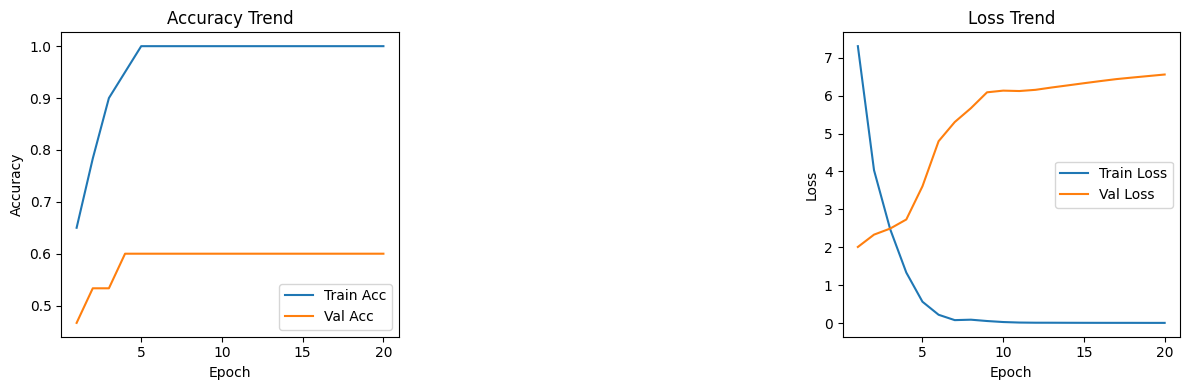

In [ ]:
epochs = np.arange(1, epochs + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(epochs, history['train_acc'], label='Train Acc')
plt.plot(epochs, history['val_acc'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Trend')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(epochs, history['train_loss'], label='Train Loss')
plt.plot(epochs, history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend')
plt.legend()

plt.tight_layout()
plt.show()


Confusion Matrix:
[[2 5]
 [1 7]]

Classification Report:
              precision    recall  f1-score   support

 Not Violent       0.67      0.29      0.40         7
     Violent       0.58      0.88      0.70         8

    accuracy                           0.60        15
   macro avg       0.62      0.58      0.55        15
weighted avg       0.62      0.60      0.56        15



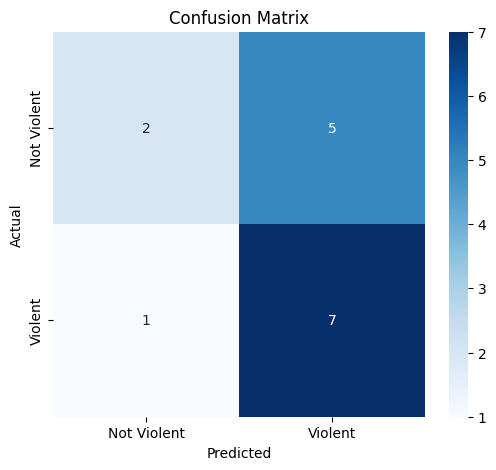

In [ ]:
cm = confusion_matrix(gt_labels, pred_labels)
report = classification_report(gt_labels, pred_labels, target_names=['Not Violent', 'Violent'])
print("Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(report)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Violent', 'Violent'], yticklabels=['Not Violent', 'Violent'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


Analyze the video:


In [ ]:
model = SimpleGRUClassifier()
model.load_state_dict(torch.load("gru_violent_model.pth", map_location=device))
model.to(device)
model.eval()

SimpleGRUClassifier(
  (gru): GRU(2051, 512, num_layers=2, batch_first=True, bidirectional=True)
  (fc_violent): Linear(in_features=1024, out_features=1, bias=True)
)

1. Whole video at once

In [ ]:
def extract_features_from_video_for_model_full(video_path):

    video_filename = video_path.split('/')[-1]

    clip = VideoFileClip(video_path)
    print(f"Processing {video_filename} ({int(clip.duration)} seconds)")
    duration = int(clip.duration)

    features = []
    for t in tqdm(range(duration), desc="Extracting frames"):
        frame = clip.get_frame(t)
        embedding = extract_face_embedding_and_pose(frame)
        if embedding is not None:
            features.append(embedding)

    features = np.array(features)

    if features.shape[0] == 0:
        print(f"\nNo embeddings extracted for {video_filename}.")
        return torch.tensor([]), 0

    print(f"Extracted {features.shape} embeddings")

    return features

In [ ]:
def analyze_video_full(video_path, model):
        features= extract_features_from_video_for_model_full(video_path)
        features_tensor = torch.tensor(features, dtype=torch.float32).unsqueeze(0).to(device)
        seq_len = torch.tensor([features.shape[0]]).to(device)

        with torch.no_grad():
            pred_violent = model(features_tensor, seq_len)

        pred_violent = pred_violent.item()

        return{
            "is_violent": pred_violent > 0.5,
            "prob_violent": round(pred_violent, 3),
        }


In [ ]:
video_name = "Bodycam Shows Suspect Shooting Oklahoma City Cop at Close Range During Pat-Down.mp4"
video_path = os.path.join(video_dir, video_name)
analyze_video_full(video_path, model)

Processing Bodycam Shows Suspect Shooting Oklahoma City Cop at Close Range During Pat-Down.mp4 (133 seconds)


Extracting frames:  41%|████▏     | 55/133 [00:34<00:40,  1.93it/s]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/face_alignment/api.py:147: UserWarning: No faces were detected.
  warnings.warn("No faces were detected.")

Extracting frames: 100%|██████████| 133/133 [01:26<00:00,  1.54it/s]

Extracted (39, 2051) embeddings


{'is_violent': True, 'prob_violent': 1.0}

In [ ]:
video_name = "Bodycam Captures Tampa Police Chief Using Position To Get Out of Traffic Violation.mp4"
video_path = os.path.join(video_dir, video_name)
analyze_video_full(video_path, model)

Processing Bodycam Captures Tampa Police Chief Using Position To Get Out of Traffic Violation.mp4 (134 seconds)


Extracting frames: 100%|██████████| 134/134 [01:23<00:00,  1.61it/s]

Extracted (74, 2051) embeddings


{'is_violent': False, 'prob_violent': 0.001}

2. Analyzing in temporal manner

In [ ]:
def detect_first_face(video_path):
    clip = VideoFileClip(video_path)
    duration = int(clip.duration)

    for t in tqdm(range(duration), desc="Detecting first face"):
        frame = clip.get_frame(t)
        embedding = extract_face_embedding_and_pose(frame)
        if embedding is not None:
            return True,t,duration

    return False,0,duration

In [ ]:
def extract_features_from_video_for_model(video_path,start_time,end_time):

    video_filename = video_path.split('/')[-1]

    clip = VideoFileClip(video_path)
    print(f"Processing {video_filename} ({int(clip.duration)} seconds)")

    clip = clip.subclip(start_time, end_time)

    duration = int(clip.duration)

    features = []
    for t in tqdm(range(duration), desc="Extracting frames"):
        frame = clip.get_frame(t)
        embedding = extract_face_embedding_and_pose(frame)
        if embedding is not None:
            features.append(embedding)

    f = features.copy()
    features = np.array(features)

    if features.shape[0] == 0:
        print(f"\nNo embeddings extracted for {video_filename}.")
        return torch.tensor([]), 0

    print(f"Extracted {features.shape} embeddings")

    return f

In [ ]:
def analyze_video_incremental(video_path, model):
    face, stmp, dur = detect_first_face(video_path)
    print(stmp,dur)
    predictions = []
    timestamps = range(stmp,dur,2)
    if face:
        pred = 0.0
        f = []
        for i in range(stmp,dur,2):

            if i-2 < stmp:
              start = stmp
            else:
              start = i-2

            features= extract_features_from_video_for_model(video_path,start,i)
            if isinstance(features,tuple):
                predictions.append(pred)
                continue

            f.extend(features)
            f_arr = np.array(f)
            features_tensor = torch.tensor(f_arr, dtype=torch.float32).unsqueeze(0).to(device)
            seq_len = torch.tensor([f_arr.shape[0]]).to(device)


            with torch.no_grad():
              pred_violent = model(features_tensor, seq_len)

            predictions.append(pred_violent[0])
            if pred_violent != pred:
              pred = pred_violent[0]

    return predictions,timestamps

In [ ]:
def plot_incremental_analysis(predictions,timestamps):
  plt.figure(figsize=(10, 6))
  plt.plot(timestamps, predictions, marker='o', linestyle='-')
  plt.xlabel("Time (seconds)")
  plt.ylabel("Violent Prediction Score")
  plt.title("Violent Prediction Score over Time")
  plt.grid(True)
  plt.show()

Detecting first face:   4%|▍         | 5/133 [00:02<01:05,  1.95it/s]


5 133
Processing Bodycam Shows Suspect Shooting Oklahoma City Cop at Close Range During Pat-Down.mp4 (133 seconds)


Extracting frames: 0it [00:00, ?it/s]



No embeddings extracted for Bodycam Shows Suspect Shooting Oklahoma City Cop at Close Range During Pat-Down.mp4.
Processing Bodycam Shows Suspect Shooting Oklahoma City Cop at Close Range During Pat-Down.mp4 (133 seconds)


Extracting frames: 100%|██████████| 2/2 [00:00<00:00,  2.90it/s]



No embeddings extracted for Bodycam Shows Suspect Shooting Oklahoma City Cop at Close Range During Pat-Down.mp4.
Processing Bodycam Shows Suspect Shooting Oklahoma City Cop at Close Range During Pat-Down.mp4 (133 seconds)


Extracting frames: 100%|██████████| 2/2 [00:02<00:00,  1.18s/it]



No embeddings extracted for Bodycam Shows Suspect Shooting Oklahoma City Cop at Close Range During Pat-Down.mp4.
Processing Bodycam Shows Suspect Shooting Oklahoma City Cop at Close Range During Pat-Down.mp4 (133 seconds)


Extracting frames: 100%|██████████| 2/2 [00:00<00:00,  2.75it/s]



No embeddings extracted for Bodycam Shows Suspect Shooting Oklahoma City Cop at Close Range During Pat-Down.mp4.
Processing Bodycam Shows Suspect Shooting Oklahoma City Cop at Close Range During Pat-Down.mp4 (133 seconds)


Extracting frames: 100%|██████████| 2/2 [00:00<00:00,  2.17it/s]



No embeddings extracted for Bodycam Shows Suspect Shooting Oklahoma City Cop at Close Range During Pat-Down.mp4.
Processing Bodycam Shows Suspect Shooting Oklahoma City Cop at Close Range During Pat-Down.mp4 (133 seconds)


Extracting frames: 100%|██████████| 2/2 [00:00<00:00,  2.33it/s]



No embeddings extracted for Bodycam Shows Suspect Shooting Oklahoma City Cop at Close Range During Pat-Down.mp4.
Processing Bodycam Shows Suspect Shooting Oklahoma City Cop at Close Range During Pat-Down.mp4 (133 seconds)


Extracting frames: 100%|██████████| 2/2 [00:01<00:00,  1.30it/s]


Extracted (1, 2051) embeddings
Processing Bodycam Shows Suspect Shooting Oklahoma City Cop at Close Range During Pat-Down.mp4 (133 seconds)


Extracting frames: 100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


Extracted (1, 2051) embeddings
Processing Bodycam Shows Suspect Shooting Oklahoma City Cop at Close Range During Pat-Down.mp4 (133 seconds)


Extracting frames: 100%|██████████| 2/2 [00:00<00:00,  2.62it/s]



No embeddings extracted for Bodycam Shows Suspect Shooting Oklahoma City Cop at Close Range During Pat-Down.mp4.
Processing Bodycam Shows Suspect Shooting Oklahoma City Cop at Close Range During Pat-Down.mp4 (133 seconds)


Extracting frames: 100%|██████████| 2/2 [00:00<00:00,  2.31it/s]



No embeddings extracted for Bodycam Shows Suspect Shooting Oklahoma City Cop at Close Range During Pat-Down.mp4.
Processing Bodycam Shows Suspect Shooting Oklahoma City Cop at Close Range During Pat-Down.mp4 (133 seconds)


Extracting frames: 100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


Extracted (1, 2051) embeddings
Processing Bodycam Shows Suspect Shooting Oklahoma City Cop at Close Range During Pat-Down.mp4 (133 seconds)


Extracting frames: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


Extracted (2, 2051) embeddings
Processing Bodycam Shows Suspect Shooting Oklahoma City Cop at Close Range During Pat-Down.mp4 (133 seconds)


Extracting frames: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


Extracted (2, 2051) embeddings
Processing Bodycam Shows Suspect Shooting Oklahoma City Cop at Close Range During Pat-Down.mp4 (133 seconds)


Extracting frames: 100%|██████████| 2/2 [00:00<00:00,  3.12it/s]



No embeddings extracted for Bodycam Shows Suspect Shooting Oklahoma City Cop at Close Range During Pat-Down.mp4.
Processing Bodycam Shows Suspect Shooting Oklahoma City Cop at Close Range During Pat-Down.mp4 (133 seconds)


Extracting frames: 100%|██████████| 2/2 [00:00<00:00,  3.52it/s]



No embeddings extracted for Bodycam Shows Suspect Shooting Oklahoma City Cop at Close Range During Pat-Down.mp4.
Processing Bodycam Shows Suspect Shooting Oklahoma City Cop at Close Range During Pat-Down.mp4 (133 seconds)


Extracting frames: 100%|██████████| 2/2 [00:00<00:00,  2.95it/s]



No embeddings extracted for Bodycam Shows Suspect Shooting Oklahoma City Cop at Close Range During Pat-Down.mp4.
Processing Bodycam Shows Suspect Shooting Oklahoma City Cop at Close Range During Pat-Down.mp4 (133 seconds)


Extracting frames: 100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


Extracted (1, 2051) embeddings
Processing Bodycam Shows Suspect Shooting Oklahoma City Cop at Close Range During Pat-Down.mp4 (133 seconds)


Extracting frames: 100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


Extracted (2, 2051) embeddings
Processing Bodycam Shows Suspect Shooting Oklahoma City Cop at Close Range During Pat-Down.mp4 (133 seconds)


Extracting frames: 100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


Extracted (2, 2051) embeddings
Processing Bodycam Shows Suspect Shooting Oklahoma City Cop at Close Range During Pat-Down.mp4 (133 seconds)


Extracting frames: 100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


Extracted (2, 2051) embeddings
Processing Bodycam Shows Suspect Shooting Oklahoma City Cop at Close Range During Pat-Down.mp4 (133 seconds)


Extracting frames: 100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


Extracted (1, 2051) embeddings
Processing Bodycam Shows Suspect Shooting Oklahoma City Cop at Close Range During Pat-Down.mp4 (133 seconds)


Extracting frames: 100%|██████████| 2/2 [00:01<00:00,  1.86it/s]



No embeddings extracted for Bodycam Shows Suspect Shooting Oklahoma City Cop at Close Range During Pat-Down.mp4.
Processing Bodycam Shows Suspect Shooting Oklahoma City Cop at Close Range During Pat-Down.mp4 (133 seconds)


Extracting frames: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


Extracted (1, 2051) embeddings
Processing Bodycam Shows Suspect Shooting Oklahoma City Cop at Close Range During Pat-Down.mp4 (133 seconds)


Extracting frames: 100%|██████████| 2/2 [00:00<00:00,  2.14it/s]



No embeddings extracted for Bodycam Shows Suspect Shooting Oklahoma City Cop at Close Range During Pat-Down.mp4.
Processing Bodycam Shows Suspect Shooting Oklahoma City Cop at Close Range During Pat-Down.mp4 (133 seconds)


Extracting frames: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


Extracted (1, 2051) embeddings
Processing Bodycam Shows Suspect Shooting Oklahoma City Cop at Close Range During Pat-Down.mp4 (133 seconds)


Extracting frames: 100%|██████████| 2/2 [00:00<00:00,  2.50it/s]



No embeddings extracted for Bodycam Shows Suspect Shooting Oklahoma City Cop at Close Range During Pat-Down.mp4.
Processing Bodycam Shows Suspect Shooting Oklahoma City Cop at Close Range During Pat-Down.mp4 (133 seconds)


Extracting frames: 100%|██████████| 2/2 [00:01<00:00,  1.25it/s]


Extracted (1, 2051) embeddings
Processing Bodycam Shows Suspect Shooting Oklahoma City Cop at Close Range During Pat-Down.mp4 (133 seconds)


Extracting frames: 100%|██████████| 2/2 [00:00<00:00,  2.40it/s]



No embeddings extracted for Bodycam Shows Suspect Shooting Oklahoma City Cop at Close Range During Pat-Down.mp4.
Processing Bodycam Shows Suspect Shooting Oklahoma City Cop at Close Range During Pat-Down.mp4 (133 seconds)


Extracting frames: 100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


Extracted (1, 2051) embeddings
Processing Bodycam Shows Suspect Shooting Oklahoma City Cop at Close Range During Pat-Down.mp4 (133 seconds)


Extracting frames: 100%|██████████| 2/2 [00:00<00:00,  2.68it/s]



No embeddings extracted for Bodycam Shows Suspect Shooting Oklahoma City Cop at Close Range During Pat-Down.mp4.
Processing Bodycam Shows Suspect Shooting Oklahoma City Cop at Close Range During Pat-Down.mp4 (133 seconds)


Extracting frames: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


Extracted (1, 2051) embeddings
Processing Bodycam Shows Suspect Shooting Oklahoma City Cop at Close Range During Pat-Down.mp4 (133 seconds)


Extracting frames: 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]



No embeddings extracted for Bodycam Shows Suspect Shooting Oklahoma City Cop at Close Range During Pat-Down.mp4.
Processing Bodycam Shows Suspect Shooting Oklahoma City Cop at Close Range During Pat-Down.mp4 (133 seconds)


Extracting frames: 100%|██████████| 2/2 [00:01<00:00,  1.91it/s]



No embeddings extracted for Bodycam Shows Suspect Shooting Oklahoma City Cop at Close Range During Pat-Down.mp4.
Processing Bodycam Shows Suspect Shooting Oklahoma City Cop at Close Range During Pat-Down.mp4 (133 seconds)


Extracting frames: 100%|██████████| 2/2 [00:00<00:00,  2.51it/s]



No embeddings extracted for Bodycam Shows Suspect Shooting Oklahoma City Cop at Close Range During Pat-Down.mp4.
Processing Bodycam Shows Suspect Shooting Oklahoma City Cop at Close Range During Pat-Down.mp4 (133 seconds)


Extracting frames: 100%|██████████| 2/2 [00:00<00:00,  2.67it/s]



No embeddings extracted for Bodycam Shows Suspect Shooting Oklahoma City Cop at Close Range During Pat-Down.mp4.
Processing Bodycam Shows Suspect Shooting Oklahoma City Cop at Close Range During Pat-Down.mp4 (133 seconds)


Extracting frames: 100%|██████████| 2/2 [00:00<00:00,  2.58it/s]



No embeddings extracted for Bodycam Shows Suspect Shooting Oklahoma City Cop at Close Range During Pat-Down.mp4.
Processing Bodycam Shows Suspect Shooting Oklahoma City Cop at Close Range During Pat-Down.mp4 (133 seconds)


Extracting frames: 100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


Extracted (1, 2051) embeddings
Processing Bodycam Shows Suspect Shooting Oklahoma City Cop at Close Range During Pat-Down.mp4 (133 seconds)


Extracting frames: 100%|██████████| 2/2 [00:01<00:00,  1.94it/s]


Extracted (1, 2051) embeddings
Processing Bodycam Shows Suspect Shooting Oklahoma City Cop at Close Range During Pat-Down.mp4 (133 seconds)


Extracting frames: 100%|██████████| 2/2 [00:00<00:00,  2.01it/s]


Extracted (1, 2051) embeddings
Processing Bodycam Shows Suspect Shooting Oklahoma City Cop at Close Range During Pat-Down.mp4 (133 seconds)


Extracting frames: 100%|██████████| 2/2 [00:00<00:00,  2.92it/s]



No embeddings extracted for Bodycam Shows Suspect Shooting Oklahoma City Cop at Close Range During Pat-Down.mp4.
Processing Bodycam Shows Suspect Shooting Oklahoma City Cop at Close Range During Pat-Down.mp4 (133 seconds)


Extracting frames: 100%|██████████| 2/2 [00:00<00:00,  2.54it/s]



No embeddings extracted for Bodycam Shows Suspect Shooting Oklahoma City Cop at Close Range During Pat-Down.mp4.
Processing Bodycam Shows Suspect Shooting Oklahoma City Cop at Close Range During Pat-Down.mp4 (133 seconds)


Extracting frames: 100%|██████████| 2/2 [00:00<00:00,  2.60it/s]



No embeddings extracted for Bodycam Shows Suspect Shooting Oklahoma City Cop at Close Range During Pat-Down.mp4.
Processing Bodycam Shows Suspect Shooting Oklahoma City Cop at Close Range During Pat-Down.mp4 (133 seconds)


Extracting frames: 100%|██████████| 2/2 [00:03<00:00,  1.73s/it]



No embeddings extracted for Bodycam Shows Suspect Shooting Oklahoma City Cop at Close Range During Pat-Down.mp4.
Processing Bodycam Shows Suspect Shooting Oklahoma City Cop at Close Range During Pat-Down.mp4 (133 seconds)


Extracting frames: 100%|██████████| 2/2 [00:00<00:00,  2.56it/s]



No embeddings extracted for Bodycam Shows Suspect Shooting Oklahoma City Cop at Close Range During Pat-Down.mp4.
Processing Bodycam Shows Suspect Shooting Oklahoma City Cop at Close Range During Pat-Down.mp4 (133 seconds)


Extracting frames: 100%|██████████| 2/2 [00:00<00:00,  2.66it/s]



No embeddings extracted for Bodycam Shows Suspect Shooting Oklahoma City Cop at Close Range During Pat-Down.mp4.
Processing Bodycam Shows Suspect Shooting Oklahoma City Cop at Close Range During Pat-Down.mp4 (133 seconds)


Extracting frames: 100%|██████████| 2/2 [00:01<00:00,  1.80it/s]


Extracted (1, 2051) embeddings
Processing Bodycam Shows Suspect Shooting Oklahoma City Cop at Close Range During Pat-Down.mp4 (133 seconds)


Extracting frames: 100%|██████████| 2/2 [00:01<00:00,  1.01it/s]


Extracted (2, 2051) embeddings
Processing Bodycam Shows Suspect Shooting Oklahoma City Cop at Close Range During Pat-Down.mp4 (133 seconds)


Extracting frames: 100%|██████████| 2/2 [00:01<00:00,  1.14it/s]


Extracted (2, 2051) embeddings
Processing Bodycam Shows Suspect Shooting Oklahoma City Cop at Close Range During Pat-Down.mp4 (133 seconds)


Extracting frames: 100%|██████████| 2/2 [00:01<00:00,  1.75it/s]


Extracted (1, 2051) embeddings
Processing Bodycam Shows Suspect Shooting Oklahoma City Cop at Close Range During Pat-Down.mp4 (133 seconds)


Extracting frames: 100%|██████████| 2/2 [00:00<00:00,  2.80it/s]



No embeddings extracted for Bodycam Shows Suspect Shooting Oklahoma City Cop at Close Range During Pat-Down.mp4.
Processing Bodycam Shows Suspect Shooting Oklahoma City Cop at Close Range During Pat-Down.mp4 (133 seconds)


Extracting frames: 100%|██████████| 2/2 [00:00<00:00,  3.27it/s]



No embeddings extracted for Bodycam Shows Suspect Shooting Oklahoma City Cop at Close Range During Pat-Down.mp4.
Processing Bodycam Shows Suspect Shooting Oklahoma City Cop at Close Range During Pat-Down.mp4 (133 seconds)


Extracting frames: 100%|██████████| 2/2 [00:00<00:00,  3.15it/s]



No embeddings extracted for Bodycam Shows Suspect Shooting Oklahoma City Cop at Close Range During Pat-Down.mp4.
Processing Bodycam Shows Suspect Shooting Oklahoma City Cop at Close Range During Pat-Down.mp4 (133 seconds)


Extracting frames: 100%|██████████| 2/2 [00:02<00:00,  1.01s/it]



No embeddings extracted for Bodycam Shows Suspect Shooting Oklahoma City Cop at Close Range During Pat-Down.mp4.
Processing Bodycam Shows Suspect Shooting Oklahoma City Cop at Close Range During Pat-Down.mp4 (133 seconds)


Extracting frames: 100%|██████████| 2/2 [00:02<00:00,  1.49s/it]



No embeddings extracted for Bodycam Shows Suspect Shooting Oklahoma City Cop at Close Range During Pat-Down.mp4.
Processing Bodycam Shows Suspect Shooting Oklahoma City Cop at Close Range During Pat-Down.mp4 (133 seconds)


Extracting frames: 100%|██████████| 2/2 [00:00<00:00,  3.36it/s]



No embeddings extracted for Bodycam Shows Suspect Shooting Oklahoma City Cop at Close Range During Pat-Down.mp4.
Processing Bodycam Shows Suspect Shooting Oklahoma City Cop at Close Range During Pat-Down.mp4 (133 seconds)


Extracting frames: 100%|██████████| 2/2 [00:01<00:00,  1.34it/s]


Extracted (1, 2051) embeddings
Processing Bodycam Shows Suspect Shooting Oklahoma City Cop at Close Range During Pat-Down.mp4 (133 seconds)


Extracting frames: 100%|██████████| 2/2 [00:00<00:00,  2.73it/s]



No embeddings extracted for Bodycam Shows Suspect Shooting Oklahoma City Cop at Close Range During Pat-Down.mp4.
Processing Bodycam Shows Suspect Shooting Oklahoma City Cop at Close Range During Pat-Down.mp4 (133 seconds)


Extracting frames: 100%|██████████| 2/2 [00:01<00:00,  1.76it/s]


Extracted (1, 2051) embeddings
Processing Bodycam Shows Suspect Shooting Oklahoma City Cop at Close Range During Pat-Down.mp4 (133 seconds)


Extracting frames: 100%|██████████| 2/2 [00:01<00:00,  1.90it/s]



No embeddings extracted for Bodycam Shows Suspect Shooting Oklahoma City Cop at Close Range During Pat-Down.mp4.
Processing Bodycam Shows Suspect Shooting Oklahoma City Cop at Close Range During Pat-Down.mp4 (133 seconds)


Extracting frames: 100%|██████████| 2/2 [00:01<00:00,  1.89it/s]


Extracted (1, 2051) embeddings
Processing Bodycam Shows Suspect Shooting Oklahoma City Cop at Close Range During Pat-Down.mp4 (133 seconds)


Extracting frames: 100%|██████████| 2/2 [00:00<00:00,  3.99it/s]



No embeddings extracted for Bodycam Shows Suspect Shooting Oklahoma City Cop at Close Range During Pat-Down.mp4.
Processing Bodycam Shows Suspect Shooting Oklahoma City Cop at Close Range During Pat-Down.mp4 (133 seconds)


Extracting frames: 100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


Extracted (1, 2051) embeddings
Processing Bodycam Shows Suspect Shooting Oklahoma City Cop at Close Range During Pat-Down.mp4 (133 seconds)


Extracting frames: 100%|██████████| 2/2 [00:00<00:00,  2.88it/s]



No embeddings extracted for Bodycam Shows Suspect Shooting Oklahoma City Cop at Close Range During Pat-Down.mp4.
Processing Bodycam Shows Suspect Shooting Oklahoma City Cop at Close Range During Pat-Down.mp4 (133 seconds)


Extracting frames: 100%|██████████| 2/2 [00:01<00:00,  1.80it/s]


Extracted (1, 2051) embeddings


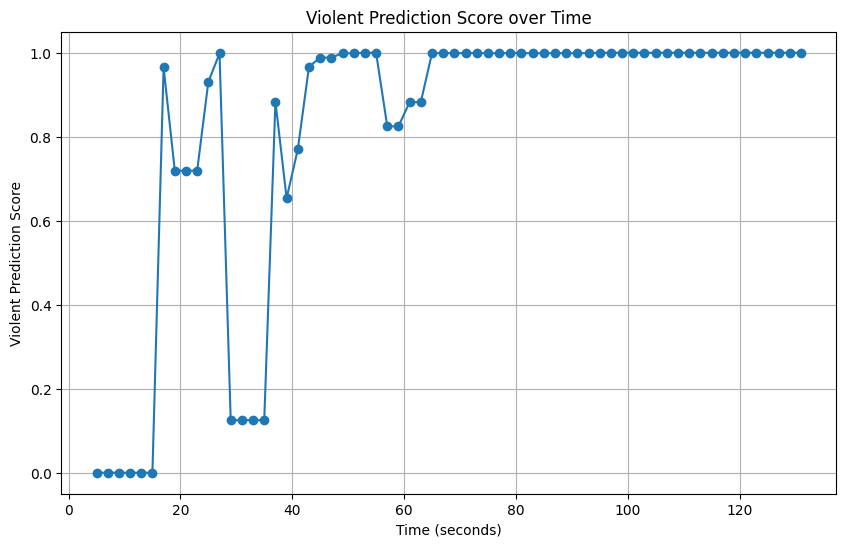

In [ ]:
video_name = "Bodycam Shows Suspect Shooting Oklahoma City Cop at Close Range During Pat-Down.mp4"
video_path = os.path.join(video_dir, video_name)
result = analyze_video_incremental(video_path, model)
p = [i if isinstance(i,float) else i.item() for i in result[0]]
t  = [i for i in result[1]]
plot_incremental_analysis(p,t)

Detecting first face:   0%|          | 0/134 [00:00<?, ?it/s]


0 134
Processing Bodycam Captures Tampa Police Chief Using Position To Get Out of Traffic Violation.mp4 (134 seconds)


Extracting frames: 0it [00:00, ?it/s]


No embeddings extracted for Bodycam Captures Tampa Police Chief Using Position To Get Out of Traffic Violation.mp4.


Processing Bodycam Captures Tampa Police Chief Using Position To Get Out of Traffic Violation.mp4 (134 seconds)


Extracting frames: 100%|██████████| 2/2 [00:01<00:00,  1.82it/s]


Extracted (1, 2051) embeddings
Processing Bodycam Captures Tampa Police Chief Using Position To Get Out of Traffic Violation.mp4 (134 seconds)


Extracting frames: 100%|██████████| 2/2 [00:01<00:00,  1.81it/s]



No embeddings extracted for Bodycam Captures Tampa Police Chief Using Position To Get Out of Traffic Violation.mp4.
Processing Bodycam Captures Tampa Police Chief Using Position To Get Out of Traffic Violation.mp4 (134 seconds)


Extracting frames: 100%|██████████| 2/2 [00:01<00:00,  1.88it/s]



No embeddings extracted for Bodycam Captures Tampa Police Chief Using Position To Get Out of Traffic Violation.mp4.
Processing Bodycam Captures Tampa Police Chief Using Position To Get Out of Traffic Violation.mp4 (134 seconds)


Extracting frames: 100%|██████████| 2/2 [00:00<00:00,  3.62it/s]



No embeddings extracted for Bodycam Captures Tampa Police Chief Using Position To Get Out of Traffic Violation.mp4.
Processing Bodycam Captures Tampa Police Chief Using Position To Get Out of Traffic Violation.mp4 (134 seconds)


Extracting frames: 100%|██████████| 2/2 [00:00<00:00,  3.02it/s]



No embeddings extracted for Bodycam Captures Tampa Police Chief Using Position To Get Out of Traffic Violation.mp4.
Processing Bodycam Captures Tampa Police Chief Using Position To Get Out of Traffic Violation.mp4 (134 seconds)


Extracting frames: 100%|██████████| 2/2 [00:00<00:00,  3.41it/s]



No embeddings extracted for Bodycam Captures Tampa Police Chief Using Position To Get Out of Traffic Violation.mp4.
Processing Bodycam Captures Tampa Police Chief Using Position To Get Out of Traffic Violation.mp4 (134 seconds)


Extracting frames: 100%|██████████| 2/2 [00:01<00:00,  1.98it/s]



No embeddings extracted for Bodycam Captures Tampa Police Chief Using Position To Get Out of Traffic Violation.mp4.
Processing Bodycam Captures Tampa Police Chief Using Position To Get Out of Traffic Violation.mp4 (134 seconds)


Extracting frames: 100%|██████████| 2/2 [00:00<00:00,  2.16it/s]



No embeddings extracted for Bodycam Captures Tampa Police Chief Using Position To Get Out of Traffic Violation.mp4.
Processing Bodycam Captures Tampa Police Chief Using Position To Get Out of Traffic Violation.mp4 (134 seconds)


Extracting frames: 100%|██████████| 2/2 [00:00<00:00,  3.45it/s]



No embeddings extracted for Bodycam Captures Tampa Police Chief Using Position To Get Out of Traffic Violation.mp4.
Processing Bodycam Captures Tampa Police Chief Using Position To Get Out of Traffic Violation.mp4 (134 seconds)


Extracting frames: 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]



No embeddings extracted for Bodycam Captures Tampa Police Chief Using Position To Get Out of Traffic Violation.mp4.
Processing Bodycam Captures Tampa Police Chief Using Position To Get Out of Traffic Violation.mp4 (134 seconds)


Extracting frames: 100%|██████████| 2/2 [00:00<00:00,  3.16it/s]



No embeddings extracted for Bodycam Captures Tampa Police Chief Using Position To Get Out of Traffic Violation.mp4.
Processing Bodycam Captures Tampa Police Chief Using Position To Get Out of Traffic Violation.mp4 (134 seconds)


Extracting frames: 100%|██████████| 2/2 [00:00<00:00,  3.72it/s]



No embeddings extracted for Bodycam Captures Tampa Police Chief Using Position To Get Out of Traffic Violation.mp4.
Processing Bodycam Captures Tampa Police Chief Using Position To Get Out of Traffic Violation.mp4 (134 seconds)


Extracting frames: 100%|██████████| 2/2 [00:00<00:00,  3.43it/s]



No embeddings extracted for Bodycam Captures Tampa Police Chief Using Position To Get Out of Traffic Violation.mp4.
Processing Bodycam Captures Tampa Police Chief Using Position To Get Out of Traffic Violation.mp4 (134 seconds)


Extracting frames: 100%|██████████| 2/2 [00:01<00:00,  1.46it/s]


Extracted (1, 2051) embeddings
Processing Bodycam Captures Tampa Police Chief Using Position To Get Out of Traffic Violation.mp4 (134 seconds)


Extracting frames: 100%|██████████| 2/2 [00:01<00:00,  1.98it/s]



No embeddings extracted for Bodycam Captures Tampa Police Chief Using Position To Get Out of Traffic Violation.mp4.
Processing Bodycam Captures Tampa Police Chief Using Position To Get Out of Traffic Violation.mp4 (134 seconds)


Extracting frames: 100%|██████████| 2/2 [00:03<00:00,  1.79s/it]


Extracted (1, 2051) embeddings
Processing Bodycam Captures Tampa Police Chief Using Position To Get Out of Traffic Violation.mp4 (134 seconds)


Extracting frames: 100%|██████████| 2/2 [00:00<00:00,  2.85it/s]



No embeddings extracted for Bodycam Captures Tampa Police Chief Using Position To Get Out of Traffic Violation.mp4.
Processing Bodycam Captures Tampa Police Chief Using Position To Get Out of Traffic Violation.mp4 (134 seconds)


Extracting frames: 100%|██████████| 2/2 [00:01<00:00,  1.85it/s]


Extracted (1, 2051) embeddings
Processing Bodycam Captures Tampa Police Chief Using Position To Get Out of Traffic Violation.mp4 (134 seconds)


Extracting frames: 100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


Extracted (2, 2051) embeddings
Processing Bodycam Captures Tampa Police Chief Using Position To Get Out of Traffic Violation.mp4 (134 seconds)


Extracting frames: 100%|██████████| 2/2 [00:01<00:00,  1.56it/s]


Extracted (2, 2051) embeddings
Processing Bodycam Captures Tampa Police Chief Using Position To Get Out of Traffic Violation.mp4 (134 seconds)


Extracting frames: 100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


Extracted (2, 2051) embeddings
Processing Bodycam Captures Tampa Police Chief Using Position To Get Out of Traffic Violation.mp4 (134 seconds)


Extracting frames: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


Extracted (2, 2051) embeddings
Processing Bodycam Captures Tampa Police Chief Using Position To Get Out of Traffic Violation.mp4 (134 seconds)


Extracting frames: 100%|██████████| 2/2 [00:01<00:00,  1.60it/s]


Extracted (2, 2051) embeddings
Processing Bodycam Captures Tampa Police Chief Using Position To Get Out of Traffic Violation.mp4 (134 seconds)


Extracting frames: 100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


Extracted (2, 2051) embeddings
Processing Bodycam Captures Tampa Police Chief Using Position To Get Out of Traffic Violation.mp4 (134 seconds)


Extracting frames: 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Extracted (2, 2051) embeddings
Processing Bodycam Captures Tampa Police Chief Using Position To Get Out of Traffic Violation.mp4 (134 seconds)


Extracting frames: 100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


Extracted (2, 2051) embeddings
Processing Bodycam Captures Tampa Police Chief Using Position To Get Out of Traffic Violation.mp4 (134 seconds)


Extracting frames: 100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


Extracted (2, 2051) embeddings
Processing Bodycam Captures Tampa Police Chief Using Position To Get Out of Traffic Violation.mp4 (134 seconds)


Extracting frames: 100%|██████████| 2/2 [00:02<00:00,  1.45s/it]


Extracted (2, 2051) embeddings
Processing Bodycam Captures Tampa Police Chief Using Position To Get Out of Traffic Violation.mp4 (134 seconds)


Extracting frames: 100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


Extracted (2, 2051) embeddings
Processing Bodycam Captures Tampa Police Chief Using Position To Get Out of Traffic Violation.mp4 (134 seconds)


Extracting frames: 100%|██████████| 2/2 [00:01<00:00,  1.68it/s]


Extracted (2, 2051) embeddings
Processing Bodycam Captures Tampa Police Chief Using Position To Get Out of Traffic Violation.mp4 (134 seconds)


Extracting frames: 100%|██████████| 2/2 [00:01<00:00,  1.54it/s]


Extracted (2, 2051) embeddings
Processing Bodycam Captures Tampa Police Chief Using Position To Get Out of Traffic Violation.mp4 (134 seconds)


Extracting frames: 100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


Extracted (2, 2051) embeddings
Processing Bodycam Captures Tampa Police Chief Using Position To Get Out of Traffic Violation.mp4 (134 seconds)


Extracting frames: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


Extracted (2, 2051) embeddings
Processing Bodycam Captures Tampa Police Chief Using Position To Get Out of Traffic Violation.mp4 (134 seconds)


Extracting frames: 100%|██████████| 2/2 [00:01<00:00,  1.01it/s]


Extracted (2, 2051) embeddings
Processing Bodycam Captures Tampa Police Chief Using Position To Get Out of Traffic Violation.mp4 (134 seconds)


Extracting frames: 100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


Extracted (2, 2051) embeddings
Processing Bodycam Captures Tampa Police Chief Using Position To Get Out of Traffic Violation.mp4 (134 seconds)


Extracting frames: 100%|██████████| 2/2 [00:01<00:00,  1.65it/s]


Extracted (2, 2051) embeddings
Processing Bodycam Captures Tampa Police Chief Using Position To Get Out of Traffic Violation.mp4 (134 seconds)


Extracting frames: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


Extracted (2, 2051) embeddings
Processing Bodycam Captures Tampa Police Chief Using Position To Get Out of Traffic Violation.mp4 (134 seconds)


Extracting frames: 100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


Extracted (2, 2051) embeddings
Processing Bodycam Captures Tampa Police Chief Using Position To Get Out of Traffic Violation.mp4 (134 seconds)


Extracting frames: 100%|██████████| 2/2 [00:01<00:00,  1.46it/s]


Extracted (2, 2051) embeddings
Processing Bodycam Captures Tampa Police Chief Using Position To Get Out of Traffic Violation.mp4 (134 seconds)


Extracting frames: 100%|██████████| 2/2 [00:01<00:00,  1.02it/s]


Extracted (2, 2051) embeddings
Processing Bodycam Captures Tampa Police Chief Using Position To Get Out of Traffic Violation.mp4 (134 seconds)


Extracting frames: 100%|██████████| 2/2 [00:01<00:00,  1.93it/s]


Extracted (1, 2051) embeddings
Processing Bodycam Captures Tampa Police Chief Using Position To Get Out of Traffic Violation.mp4 (134 seconds)


Extracting frames: 100%|██████████| 2/2 [00:01<00:00,  1.40it/s]


Extracted (2, 2051) embeddings
Processing Bodycam Captures Tampa Police Chief Using Position To Get Out of Traffic Violation.mp4 (134 seconds)


Extracting frames: 100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


Extracted (2, 2051) embeddings
Processing Bodycam Captures Tampa Police Chief Using Position To Get Out of Traffic Violation.mp4 (134 seconds)


Extracting frames: 100%|██████████| 2/2 [00:01<00:00,  1.34it/s]


Extracted (2, 2051) embeddings
Processing Bodycam Captures Tampa Police Chief Using Position To Get Out of Traffic Violation.mp4 (134 seconds)


Extracting frames: 100%|██████████| 2/2 [00:01<00:00,  1.02it/s]


Extracted (2, 2051) embeddings
Processing Bodycam Captures Tampa Police Chief Using Position To Get Out of Traffic Violation.mp4 (134 seconds)


Extracting frames: 100%|██████████| 2/2 [00:01<00:00,  1.44it/s]


Extracted (2, 2051) embeddings
Processing Bodycam Captures Tampa Police Chief Using Position To Get Out of Traffic Violation.mp4 (134 seconds)


Extracting frames: 100%|██████████| 2/2 [00:01<00:00,  1.34it/s]


Extracted (2, 2051) embeddings
Processing Bodycam Captures Tampa Police Chief Using Position To Get Out of Traffic Violation.mp4 (134 seconds)


Extracting frames: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


Extracted (2, 2051) embeddings
Processing Bodycam Captures Tampa Police Chief Using Position To Get Out of Traffic Violation.mp4 (134 seconds)


Extracting frames: 100%|██████████| 2/2 [00:01<00:00,  1.42it/s]


Extracted (2, 2051) embeddings
Processing Bodycam Captures Tampa Police Chief Using Position To Get Out of Traffic Violation.mp4 (134 seconds)


Extracting frames: 100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


Extracted (2, 2051) embeddings
Processing Bodycam Captures Tampa Police Chief Using Position To Get Out of Traffic Violation.mp4 (134 seconds)


Extracting frames: 100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


Extracted (2, 2051) embeddings
Processing Bodycam Captures Tampa Police Chief Using Position To Get Out of Traffic Violation.mp4 (134 seconds)


Extracting frames: 100%|██████████| 2/2 [00:00<00:00,  2.07it/s]


Extracted (1, 2051) embeddings
Processing Bodycam Captures Tampa Police Chief Using Position To Get Out of Traffic Violation.mp4 (134 seconds)


Extracting frames: 100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


Extracted (2, 2051) embeddings
Processing Bodycam Captures Tampa Police Chief Using Position To Get Out of Traffic Violation.mp4 (134 seconds)


Extracting frames: 100%|██████████| 2/2 [00:01<00:00,  1.38it/s]


Extracted (2, 2051) embeddings
Processing Bodycam Captures Tampa Police Chief Using Position To Get Out of Traffic Violation.mp4 (134 seconds)


Extracting frames: 100%|██████████| 2/2 [00:00<00:00,  2.03it/s]


Extracted (1, 2051) embeddings
Processing Bodycam Captures Tampa Police Chief Using Position To Get Out of Traffic Violation.mp4 (134 seconds)


Extracting frames: 100%|██████████| 2/2 [00:00<00:00,  2.24it/s]


Extracted (1, 2051) embeddings
Processing Bodycam Captures Tampa Police Chief Using Position To Get Out of Traffic Violation.mp4 (134 seconds)


Extracting frames: 100%|██████████| 2/2 [00:00<00:00,  3.65it/s]



No embeddings extracted for Bodycam Captures Tampa Police Chief Using Position To Get Out of Traffic Violation.mp4.
Processing Bodycam Captures Tampa Police Chief Using Position To Get Out of Traffic Violation.mp4 (134 seconds)


Extracting frames: 100%|██████████| 2/2 [00:00<00:00,  3.33it/s]



No embeddings extracted for Bodycam Captures Tampa Police Chief Using Position To Get Out of Traffic Violation.mp4.
Processing Bodycam Captures Tampa Police Chief Using Position To Get Out of Traffic Violation.mp4 (134 seconds)


Extracting frames: 100%|██████████| 2/2 [00:00<00:00,  2.20it/s]



No embeddings extracted for Bodycam Captures Tampa Police Chief Using Position To Get Out of Traffic Violation.mp4.
Processing Bodycam Captures Tampa Police Chief Using Position To Get Out of Traffic Violation.mp4 (134 seconds)


Extracting frames: 100%|██████████| 2/2 [00:01<00:00,  1.97it/s]



No embeddings extracted for Bodycam Captures Tampa Police Chief Using Position To Get Out of Traffic Violation.mp4.
Processing Bodycam Captures Tampa Police Chief Using Position To Get Out of Traffic Violation.mp4 (134 seconds)


Extracting frames: 100%|██████████| 2/2 [00:00<00:00,  2.93it/s]



No embeddings extracted for Bodycam Captures Tampa Police Chief Using Position To Get Out of Traffic Violation.mp4.
Processing Bodycam Captures Tampa Police Chief Using Position To Get Out of Traffic Violation.mp4 (134 seconds)


Extracting frames: 100%|██████████| 2/2 [00:00<00:00,  3.36it/s]



No embeddings extracted for Bodycam Captures Tampa Police Chief Using Position To Get Out of Traffic Violation.mp4.
Processing Bodycam Captures Tampa Police Chief Using Position To Get Out of Traffic Violation.mp4 (134 seconds)


Extracting frames: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]



No embeddings extracted for Bodycam Captures Tampa Police Chief Using Position To Get Out of Traffic Violation.mp4.
Processing Bodycam Captures Tampa Police Chief Using Position To Get Out of Traffic Violation.mp4 (134 seconds)


Extracting frames: 100%|██████████| 2/2 [00:00<00:00,  3.70it/s]



No embeddings extracted for Bodycam Captures Tampa Police Chief Using Position To Get Out of Traffic Violation.mp4.
Processing Bodycam Captures Tampa Police Chief Using Position To Get Out of Traffic Violation.mp4 (134 seconds)


Extracting frames: 100%|██████████| 2/2 [00:00<00:00,  3.43it/s]



No embeddings extracted for Bodycam Captures Tampa Police Chief Using Position To Get Out of Traffic Violation.mp4.
Processing Bodycam Captures Tampa Police Chief Using Position To Get Out of Traffic Violation.mp4 (134 seconds)


Extracting frames: 100%|██████████| 2/2 [00:00<00:00,  2.18it/s]



No embeddings extracted for Bodycam Captures Tampa Police Chief Using Position To Get Out of Traffic Violation.mp4.


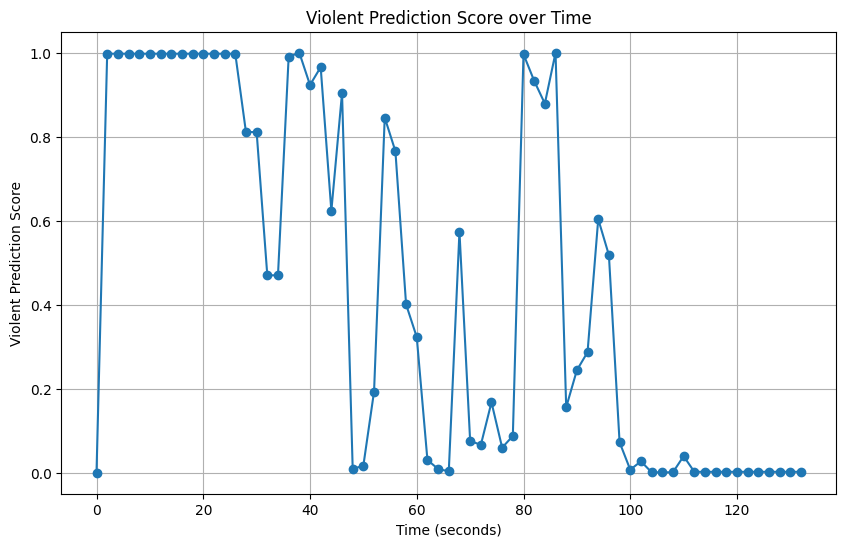

In [ ]:
video_name = "Bodycam Captures Tampa Police Chief Using Position To Get Out of Traffic Violation.mp4"
video_path = os.path.join(video_dir, video_name)
result = analyze_video_incremental(video_path, model)
p = [i if isinstance(i,float) else i.item() for i in result[0]]
t  = [i for i in result[1]]
plot_incremental_analysis(p,t)